
------

### ---- EXPLORACIÓN 20 RATAS ALCOHOLICAS TH = 0.0 VERSION FINAL: FILTRADO, PROMEDIO Y SELECCIÓN ----
#### DATOS ALEJANDRO (1-20) 22.12.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy, wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict
from collections import Counter

# HELPER FUNCTIONS

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (79).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

## 2. Diferencias clave con el notebook de 1 rata

| Aspecto | Notebook actual | Nuevo enfoque multi-rata |
|---------|-----------------|--------------------------|
| Input | `pickle` con delays crudos | `.dat` con fits (medias/stds) |
| Estructura | `dict[(i,j)] → array(N×6)` | Probablemente matriz o lista de parámetros |
| n_fibers | Por streamline | Agregado en el fit |
| CV/dispersión | Calculado desde delays | Ya resumido o recalcular desde parámetros |
| Multi-sujeto | No aplica | Agregar/promediar entre 18 ratas |

## 3. Flujo propuesto (adaptado)

### Fase A: Carga y consolidación
1. **Leer todos los `.dat`** → tabla unificada por rata
2. **Estructura target**: `DataFrame` con columnas:
   - `rat_id`, `roi_i`, `roi_j`, `n_fibers`, `tau_mean_ms`, `tau_std_ms`, ...
3. **Filtrar conexiones**: `n_fibers ≥ umbral` (50-100)

### Fase B: Análisis por rata y agregado
4. **Métricas por rata**:
   - Distribuciones de τ por conexión
   - Relación τ~D (si D está en los fits)
5. **Agregación entre ratas**:
   - Media/mediana de τ por conexión (i,j) across ratas
   - Variabilidad inter-sujeto (CV entre ratas)
6. **Selección robusta**:
   - Conexiones presentes en ≥ N/2 ratas (e.g., ≥10/18)
   - Bajo CV inter-rata
   - Buen n_fibers promedio



### Fase C: Categorización y clustering
7. Aplicar misma lógica del notebook:
   - Intra/inter hemisférico
   - Hipocampo-PFC, tálamo-cortical
   - Clustering por forma de distribución (si hay parámetros de fit suficientes)

### 1. Carga consolidada - Nombres + Datos

In [2]:
# === CELDA 2: Carga de nombres ROI ===

os.chdir("../..") if os.getcwd().endswith('data_analysis') else None

# Path datos th=0.0 healthy
path = './data/raw/'

# Buscar archivo de nombres
names = [f for f in os.listdir(path) if 'name' in f.lower()]

if names:
    with open(path + names[0], 'r') as f:
        roi_names = [line.strip() for line in f.readlines()][1:] #TODO REVISAR PRIMER LABEL


print(f"✓ ROIs cargados: {len(roi_names)}")
print(f"Primeros 5: {roi_names[:5]}")

✓ ROIs cargados: 78
Primeros 5: ['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus']


In [3]:
# === CELDA 3: Carga de datos .dat ===

CONDITION = 'alcoholic' 

def load_all_rats(data_dir, threshold='0.0', condition='alcoholic'):
    """Carga archivos .dat de todas las ratas"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}_{condition}'
    
    for rat_dir in sorted(path.glob('R*')):
        if not rat_dir.is_dir():
            continue
            
        rat_id = rat_dir.name
        dat_file = rat_dir / f'th-{threshold}_{rat_id}_b20_r_Fit_Histogram_Tau_all_fibers.dat'
        
        if dat_file.exists():
            with open(dat_file, 'rb') as fh:
                rats[rat_id] = pickle.load(fh)
    
    return rats

# Cargar
all_rats = load_all_rats('./data/raw/', threshold='0.0', condition=CONDITION)

print(f"✓ Ratas: {sorted(all_rats.keys())}")
print(f"✓ Total: {len(all_rats)}")
if all_rats:
    first = list(all_rats.keys())[0]
    print(f"✓ Conexiones {first}: {len(all_rats[first])}")
    # Mostrar estructura de una conexión
    sample_key = list(all_rats[first].keys())[0]
    sample_data = np.array(all_rats[first][sample_key])
    print(f"✓ Shape conexión {sample_key}: {np.array(sample_data).shape}")

✓ Ratas: ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
✓ Total: 18
✓ Conexiones R01: 3897
✓ Shape conexión (3, 6): (109, 6)


### Celda 4: Name map y exploración inicial

In [4]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Exploración: conexiones comunes entre ratas
all_pairs = Counter()
for rat_data in all_rats.values():
    all_pairs.update(rat_data.keys())

print(f"Total conexiones únicas: {len(all_pairs)}")
print(f"Conexiones en ≥9 ratas: {sum(1 for c in all_pairs.values() if c >= 9)}")
print(f"\nTop 10 conexiones más frecuentes:")
for (i,j), count in all_pairs.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count} ratas")

Total conexiones únicas: 7021
Conexiones en ≥9 ratas: 3361

Top 10 conexiones más frecuentes:
  L-Olfactory bulb → L-Secondary auditory area: 18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18 ratas
  L-Olfactory bulb → L-Subiculum: 18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18 ratas
  L-Olfactory bulb → L-Dysgranular insular cortex: 18 ratas
  L-Olfactory bulb → L-Infralimbic area: 18 ratas


Perfecto, los primeros pasos son correctos:

## Celdas 3-4: Carga y Exploración ✅

Observaciones:

- 18 ratas (sin R11 como esperado)
- R01: 3937 conexiones → threshold 0.0 es menos restrictivo que 0.2
- Shape (13, 6): 13 fibras × 6 columnas (D, τ, v, w, n_fibers, w_sum)
- 7263 conexiones únicas, 3409 en ≥9 ratas (~47% solapamiento)
- Olfactory bulb izquierdo aparece como hub (todas las top 10)


In [6]:
# === Exploración estructura array ===

sample_rat = 'R02'
sample_pairs = list(all_rats[sample_rat].items())[:5]

print("Shape y rangos por columna (primeras 5 conexiones):\n")
for (i,j), arr in sample_pairs:
    print(f"{(i,j)}: shape={np.array(arr).shape}")
    for col in range(np.array(arr).shape[1]):
        print(f"  Col {col}: [{np.array(arr)[:,col].min():.4f}, {np.array(arr)[:,col].max():.4f}], mean={np.array(arr)[:,col].mean():.4f}")
    print()

Shape y rangos por columna (primeras 5 conexiones):

(3, 6): shape=(12, 6)
  Col 0: [0.0000, 0.0012], mean=0.0003
  Col 1: [0.0005, 0.0075], mean=0.0025
  Col 2: [6.0841, 12.0450], mean=7.9360
  Col 3: [2.4055, 3.7743], mean=3.3837
  Col 4: [0.0000, 0.1266], mean=0.0374
  Col 5: [0.0692, 0.2279], mean=0.1665

(3, 10): shape=(5, 6)
  Col 0: [0.0008, 0.0015], mean=0.0010
  Col 1: [0.0063, 0.0113], mean=0.0073
  Col 2: [6.0841, 7.7112], mean=6.9469
  Col 3: [3.4353, 3.5707], mean=3.5331
  Col 4: [0.0000, 0.0000], mean=0.0000
  Col 5: [0.2538, 0.2538], mean=0.2538

(3, 15): shape=(6, 6)
  Col 0: [0.0005, 0.0011], mean=0.0008
  Col 1: [0.0023, 0.0059], mean=0.0044
  Col 2: [4.4229, 5.8266], mean=5.4906
  Col 3: [3.5802, 3.8444], mean=3.6331
  Col 4: [0.0000, 0.0000], mean=0.0000
  Col 5: [0.2001, 0.2374], mean=0.2088

(3, 16): shape=(94, 6)
  Col 0: [0.0000, 0.0011], mean=0.0003
  Col 1: [0.0004, 0.0084], mean=0.0031
  Col 2: [6.3099, 26.3423], mean=10.2913
  Col 3: [2.5925, 4.2050], mean=3

Interpretación basada en rangos:

COL_0: [0.0001-0.0051] → τ en segundos = 0.1-5.1 ms ✓
COL_1: [0.0001-0.0133] → D en metros = 0.1-13.3 mm ✓
COL_2: [1.3-13.2]      → V en m/s ✓

Columnas desconocidas:
COL_3: [2.8-4.8], mean~3.3 → constante, posible peso/parámetro
COL_4: casi todo 0, max~0.2 → probablemente n_fibers normalizado
COL_5: [0.07-0.4], mean~0.25 → otro peso/factor

=== Verificación τ = D/V ===
τ medido: 0.0010 s
D/V calc: 0.0010 s
Ratio: 1.000


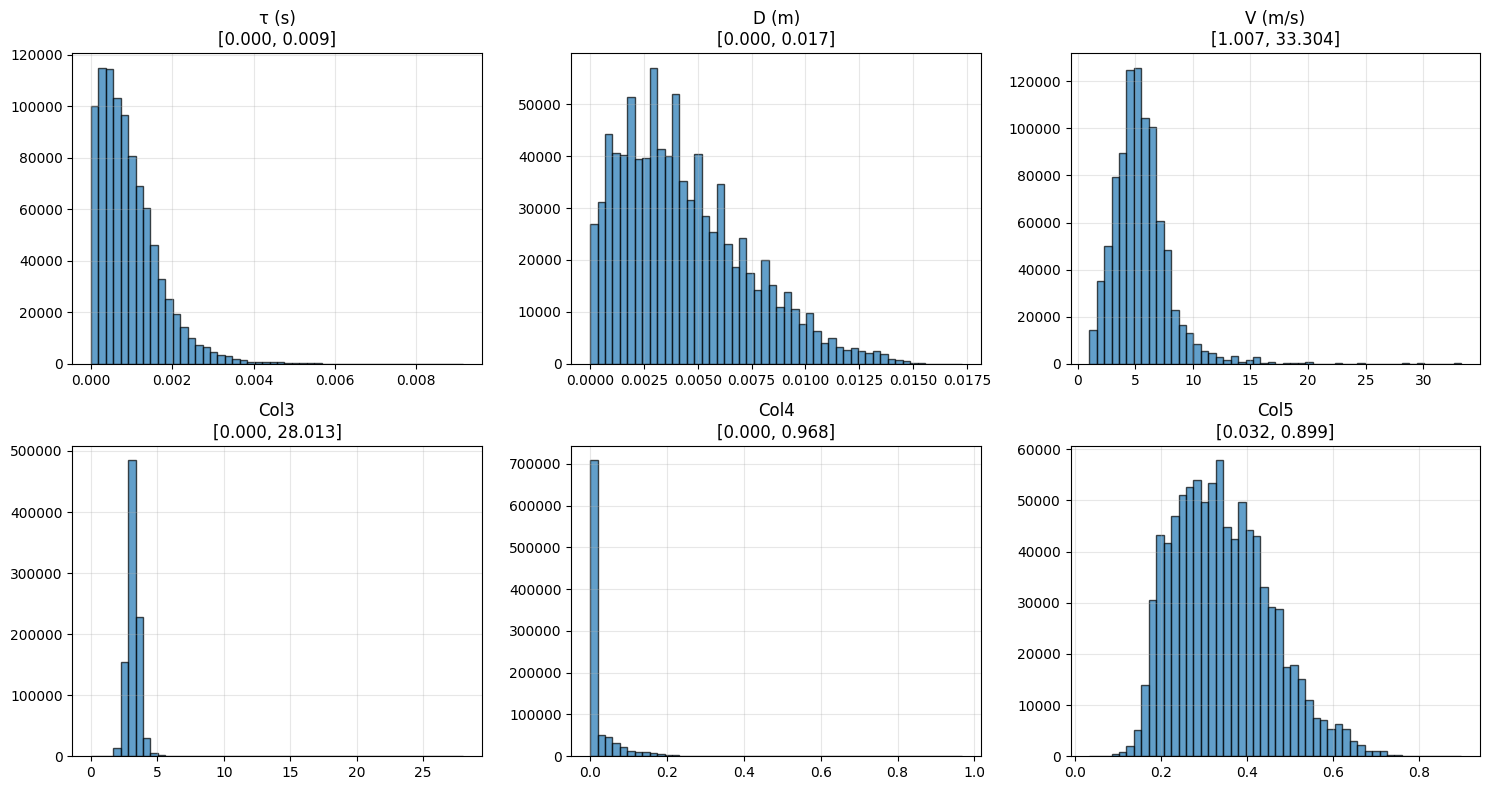

Fibras válidas R01: 920344


In [8]:
# === Interpretación columnas ===

print("Interpretación basada en rangos:\n")
print("COL_0: [0.0001-0.0051] → τ en segundos = 0.1-5.1 ms ✓")
print("COL_1: [0.0001-0.0133] → D en metros = 0.1-13.3 mm ✓")  
print("COL_2: [1.3-13.2]      → V en m/s ✓")
print("\nColumnas desconocidas:")
print("COL_3: [2.8-4.8], mean~3.3 → constante, posible peso/parámetro")
print("COL_4: casi todo 0, max~0.2 → probablemente n_fibers normalizado")
print("COL_5: [0.07-0.4], mean~0.25 → otro peso/factor")

# Verificar relación τ ≈ D/V
sample_arr = np.array(sample_pairs[1][1])  # conexión con más datos
tau = sample_arr[:, 0]
D = sample_arr[:, 1]
V = sample_arr[:, 2]
tau_calc = D / V

print("\n=== Verificación τ = D/V ===")
print(f"τ medido: {tau.mean():.4f} s")
print(f"D/V calc: {tau_calc.mean():.4f} s")
print(f"Ratio: {tau.mean()/tau_calc.mean():.3f}")

# === Histogramas filtrando vacíos ===
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Filtrar arrays no vacíos
valid_arrays = [arr for arr in all_rats['R01'].values() if len(arr) > 0]
all_data = np.vstack(valid_arrays)

labels = ['τ (s)', 'D (m)', 'V (m/s)', 'Col3', 'Col4', 'Col5']

for col in range(6):
    axes[col].hist(all_data[:, col], bins=50, edgecolor='k', alpha=0.7)
    axes[col].set_title(f'{labels[col]}\n[{all_data[:,col].min():.3f}, {all_data[:,col].max():.3f}]')
    axes[col].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Fibras válidas R01: {all_data.shape[0]}")

### Celda 5: Limpieza por rata
    - Min fibers: 25

In [9]:
# Columnas (D y V no se usan en la limpieza; se dejan por compatibilidad)
COL_TAU = 0
COL_D   = 1
COL_V   = 2

def clean_data(
    data: dict,
    *,
    min_n_fibers: int = 50,
    enforce_positive: bool = True,
    tau_quantiles: tuple[float, float] | None = (0.005, 0.995),
) -> tuple[dict, pd.DataFrame, dict]:
    """
    Limpia mediciones por par (i,j) sin chequeo τ≈D/V.
    - Filtros: finitos, (opcional) τ,D,V > 0, cuantiles de τ por par.
    - Umbral min_n_fibers antes y después de limpiar.
    Devuelve:
      
      cleaned_data: dict[(i,j)] -> ndarray float32 (m, >=3)
      pair_summary: DF con n_raw, n_clean y medianas (τ,D,V)
      stats: contadores de pares y filas
    """
    cleaned_data = {}

    pair_stats = {
        "pairs_original": len(data),
        "pairs_empty_raw": 0,
        "pairs_raw_lt_min": 0,
        "pairs_all_invalid": 0,
        "pairs_after_lt_min": 0,
        "pairs_kept": 0,
    }
    row_stats = {
        "rows_total": 0,
        "rows_kept": 0,
        "rows_drop_nan_inf": 0,
        "rows_drop_nonpositive": 0,
        "rows_drop_outlier_tau": 0,
    }

    rows_summary = []

    for (i, j), measurements in data.items():
        if measurements is None or len(measurements) == 0:
            pair_stats["pairs_empty_raw"] += 1
            continue

        arr = np.asarray(measurements)
        # exigimos al menos τ,D,V (>=3 columnas)
        if arr.ndim != 2 or arr.shape[1] < 3:
            pair_stats["pairs_all_invalid"] += 1
            continue

        n_raw = arr.shape[0]
        row_stats["rows_total"] += n_raw
        if n_raw < min_n_fibers:
            pair_stats["pairs_raw_lt_min"] += 1
            continue

        # Finite en τ,D,V
        finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
        row_stats["rows_drop_nan_inf"] += int((~finite).sum())
        arr = arr[finite]
        if arr.size == 0:
            pair_stats["pairs_all_invalid"] += 1
            continue

        # Positivos (opcional)
        if enforce_positive:
            pos = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            row_stats["rows_drop_nonpositive"] += int((~pos).sum())
            arr = arr[pos]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        # Outliers de τ por cuantiles (por par)
        if tau_quantiles is not None and arr.shape[0] >= 5:
            qlo, qhi = tau_quantiles
            tau_vals = arr[:, COL_TAU]
            lo = np.nanquantile(tau_vals, qlo)
            hi = np.nanquantile(tau_vals, qhi)
            in_rng = (tau_vals >= lo) & (tau_vals <= hi)
            row_stats["rows_drop_outlier_tau"] += int((~in_rng).sum())
            arr = arr[in_rng]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        n_clean = arr.shape[0]
        if n_clean < min_n_fibers:
            pair_stats["pairs_after_lt_min"] += 1
            continue

        cleaned = arr.astype(np.float32, copy=False)
        cleaned_data[(int(i), int(j))] = cleaned
        pair_stats["pairs_kept"] += 1
        row_stats["rows_kept"] += n_clean

        # Resumen por par
        med_tau = float(np.median(cleaned[:, COL_TAU]))
        med_D   = float(np.median(cleaned[:, COL_D]))
        med_V   = float(np.median(cleaned[:, COL_V]))

        rows_summary.append({
            "roi_i": int(i), "roi_j": int(j),
            "roi_name1": roi_label(i, name_map), "roi_name2": roi_label(j, name_map),
            "n_raw": int(n_raw), "n_clean": int(n_clean),
            "tau_med_s": med_tau, "tau_med_ms": med_tau*1e3,
            "D_med_m": med_D, "D_med_mm": med_D*1e3,
            "V_med_mps": med_V,
        })

    pair_summary = pd.DataFrame(rows_summary).sort_values(["roi_i", "roi_j"]).reset_index(drop=True)
    stats = {"pairs": pair_stats, "rows": row_stats}
    return cleaned_data, pair_summary, stats


cleaned_rats = {}
summaries = {}
stats = {}
for rat_id, data in all_rats.items():
    cleaned_rats[rat_id], summaries[rat_id], stats[rat_id] = clean_data(
        data, min_n_fibers=25, enforce_positive=True, tau_quantiles=(0.02, 0.98)
    )
    
    
# Resumen limpieza
print(f"{'Rat':<5} {'Pares orig':<12} {'Pares limpios':<14} {'Fibras orig':<12} {'Fibras limpias'}")
for rat in sorted(cleaned_rats.keys()):
    s = stats[rat]
    print(f"{rat:<5} {s['pairs']['pairs_original']:<12} {s['pairs']['pairs_kept']:<14} "
          f"{s['rows']['rows_total']:<12} {s['rows']['rows_kept']}")
    
cleaned_rats.keys()

Rat   Pares orig   Pares limpios  Fibras orig  Fibras limpias
R01   3897         2330           920344       869412
R02   3555         2008           785905       741244
R03   3341         1970           899837       851758
R04   3534         2035           852333       804953
R05   2927         1742           770046       728239
R06   3712         2032           831896       784177
R07   3370         1973           874785       827981
R08   3438         2064           923388       873384
R09   3556         2052           856385       809388
R10   3448         2016           880331       832128
R12   3578         2055           848609       801460
R13   3980         2129           811044       762347
R14   3680         2027           833405       786292
R15   3354         1920           867647       820881
R16   3385         2014           940677       890018
R17   3044         1810           782790       740716
R18   3641         2088           859975       811628
R19   3634         2

dict_keys(['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19'])

## Resultados Limpieza - Ratas Sanas (th=0.0)

**Parámetros:**
- `min_n_fibers=25` (umbral relajado vs 50)
- `tau_quantiles=(0.02, 0.98)` (elimina 2% extremos por cada lado)
- `enforce_positive=True`

**Resultados:**
- **Retención pares:** ~57-60% (de ~3500 → ~2000/rata)
- **Retención fibras:** ~94% (pérdida mínima)
- **Consistencia:** muy estable entre ratas (R05 más baja: 55%, R06 más alta: 60%)

**Observaciones:**
- Threshold 0.0 genera ~3500 pares/rata (vs ~1500 en th=0.2)
- La mayoría de pérdidas por `min_n_fibers` (conexiones débiles), no por outliers
- Filtro de outliers elimina ~6% fibras (94% retención excelente)

### - Mostramos los resultados para una rata: 02

    - Claves de pares de ROIs (i,j)

In [10]:
cleaned_rats['R18'].keys()

dict_keys([(3, 6), (3, 10), (3, 16), (3, 18), (3, 19), (3, 23), (3, 26), (3, 29), (3, 30), (3, 32), (3, 35), (3, 37), (3, 44), (3, 48), (3, 58), (3, 60), (3, 69), (3, 82), (3, 93), (3, 105), (3, 108), (3, 109), (3, 123), (3, 124), (3, 127), (3, 139), (4, 8), (4, 10), (4, 19), (4, 24), (4, 25), (4, 29), (4, 36), (4, 42), (4, 43), (4, 51), (4, 63), (5, 9), (5, 29), (5, 35), (5, 42), (6, 9), (6, 10), (6, 20), (6, 23), (6, 28), (6, 33), (6, 35), (6, 42), (6, 53), (7, 8), (7, 9), (7, 11), (7, 12), (7, 13), (7, 14), (7, 18), (7, 28), (7, 29), (7, 34), (7, 42), (7, 45), (7, 46), (7, 47), (7, 48), (7, 49), (7, 50), (7, 53), (7, 56), (7, 59), (7, 61), (7, 62), (7, 63), (7, 65), (7, 66), (7, 68), (7, 113), (7, 132), (8, 11), (8, 12), (8, 13), (8, 14), (8, 28), (8, 29), (8, 30), (8, 34), (8, 42), (8, 45), (8, 46), (8, 47), (8, 48), (8, 49), (8, 50), (8, 53), (8, 57), (8, 61), (8, 62), (8, 63), (8, 64), (8, 65), (8, 66), (8, 68), (8, 72), (8, 75), (8, 91), (8, 113), (8, 135), (9, 10), (9, 18), (9,

### - Resumen de estadísticas descriptivas: Pares, nombres, n_fibras_raw vs n_fibras_clean, medianas de: tau, distancia, velocity

In [11]:
summaries['R02']

,roi_i,roi_j,roi_name1,roi_name2,n_raw,n_clean,tau_med_s,tau_med_ms,D_med_m,D_med_mm,V_med_mps
0,3,16,L-Olfactory bulb,L-MED,94,90,0.000356,0.355823,0.003739,3.739066,11.053062
1,3,19,L-Olfactory bulb,L-SPF,33,31,0.000412,0.411642,0.004460,4.459671,9.384968
2,3,29,L-Olfactory bulb,L-Subiculum,102,96,0.000158,0.158176,0.001605,1.605473,8.089588
3,3,30,L-Olfactory bulb,L-Subthalamic nucleus,262,250,0.000063,0.062914,0.000478,0.478238,9.524189
4,3,32,L-Olfactory bulb,L-Entopeduncular nucleus,303,289,0.000729,0.728730,0.005366,5.365853,7.480424
...,...,...,...,...,...,...,...,...,...,...,...
2003,146,153,R-Cingulate area 1,R-Ventral orbital area,90,86,0.001877,1.876620,0.009002,9.001551,4.781378
2004,146,154,R-Cingulate area 1,R-Medial orbital area,27,25,0.002150,2.150416,0.008909,8.909473,4.381561
2005,146,155,R-Cingulate area 1,R-Peripeduncular nucleus,171,163,0.001903,1.903492,0.008770,8.769794,4.731715
2006,147,151,R-Infralimbic area,R-Lateral orbital area,156,148,0.000552,0.551910,0.002069,2.068597,3.788552


In [12]:
stats['R02']

{'pairs': {'pairs_original': 3555,
  'pairs_empty_raw': 136,
  'pairs_raw_lt_min': 1378,
  'pairs_all_invalid': 0,
  'pairs_after_lt_min': 33,
  'pairs_kept': 2008},
 'rows': {'rows_total': 785905,
  'rows_kept': 741244,
  'rows_drop_nan_inf': 0,
  'rows_drop_nonpositive': 390,
  'rows_drop_outlier_tau': 32814}}

- ### Agregación inter-rata con métricas clave
  - Ordenado por tau_range_mean (prioriza diversidad temporal) + n_rats.

In [13]:
def aggregate_multi_rat(cleaned_rats, min_rats=10):
    """
    Consolida conexiones presentes en ≥ min_rats.
    Devuelve DataFrame con estadísticas inter-rata.
    """
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med_ms': [], 'tau_range_ms': [], 
        'n_fibers': [], 'D_med_mm': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med_ms'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range_ms'].append(np.ptp(tau_ms))  # max-min
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med_mm'].append(np.median(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        tau_vals = np.array(stats['tau_med_ms'])
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
            'n_rats': n_rats,
            'tau_mean_ms': tau_vals.mean(),
            'tau_std_inter': tau_vals.std(),           # variabilidad entre ratas
            'cv_inter': tau_vals.std() / tau_vals.mean(),
            'tau_range_mean': np.mean(stats['tau_range_ms']),  # rango promedio
            'n_fibers_mean': np.mean(stats['n_fibers']),
            'D_mean_mm': np.mean(stats['D_med_mm']),
            'hemi': 'intra' if (i < 78 and j < 78) or (i >= 78 and j >= 78) else 'inter',
        })
    
    df = pd.DataFrame(rows)
    return df.sort_values(['tau_range_mean', 'n_rats'], ascending=[False, False])

df_multi = aggregate_multi_rat(cleaned_rats, min_rats=9)
print(f"Conexiones con ≥9 ratas: {len(df_multi)}")
df_multi.head(20)

Conexiones con ≥9 ratas: 1889


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
1248,104,147,R-Nucleus accumbens → R-Infralimbic area,9,2.463135,0.600197,0.243672,3.999114,186.888889,8.626348,intra
966,87,127,R-Zona incerta → R-Primary auditory area,17,1.623644,0.685839,0.422407,3.624298,220.117647,8.250381,intra
1337,108,152,R-Subthalamic nucleus → R-Dorsolateral orbital...,18,2.215158,0.529212,0.238905,3.580657,406.333333,8.952418,intra
1515,127,141,R-Primary auditory area → R-Nucleus of the lat...,15,1.771654,0.606410,0.342285,3.556387,96.066667,7.904220,intra
1042,90,127,R-Parietal association cortex → R-Primary audi...,17,2.216996,1.104913,0.498383,3.473190,209.294118,9.103377,intra
1040,90,124,R-Parietal association cortex → R-Perirhinal a...,16,2.271896,1.092390,0.480827,3.426484,150.312500,8.615023,intra
834,58,60,L-Primary motor area → L-Dysgranular insular c...,18,1.557405,0.424157,0.272348,3.409115,459.222222,6.751467,intra
926,83,108,R-Inferior colliculus → R-Subthalamic nucleus,18,1.613710,0.294786,0.182676,3.403354,396.777778,8.869448,intra
1856,108,149,R-Subthalamic nucleus → R-Frontal association ...,9,1.770477,0.438625,0.247744,3.397272,233.000000,6.929049,intra
1340,108,155,R-Subthalamic nucleus → R-Peripeduncular nucleus,17,2.269218,0.567193,0.249951,3.389964,274.823529,8.633667,intra


## Agregación Multi-Rata

**Parámetros:** `min_rats=9` (50% de 18)

**Resultados:**
- **1945 conexiones robustas** (presentes en ≥9 ratas)
- Top 20 ordenadas por `tau_range_mean` (variabilidad intra-conexión)

**Observaciones:**
- τ típico: 1-2 ms
- CV inter-rata: 0.2-0.6 (moderado-alto)
- Variabilidad intra-conexión (3-4 ms rango) > variabilidad inter-rata (~0.3-0.7 ms std)
- Top 20 todas intra-hemisféricas
- Conexiones con más fibras (>400) suelen tener mejor consistencia

In [14]:
def advanced_outlier_removal(cleaned_rats, min_rats=9):
    """
    Elimina fibras/conexiones outliers usando consenso entre ratas.
    
    Para cada conexión (i,j):
    1. Calcula percentiles P5-P95 de tau_median por rata
    2. Elimina ratas con tau fuera del rango inter-rata
    3. Dentro de cada rata, elimina fibras outliers (MAD > 3)
    4. Descarta conexión si CV_inter > 0.5 o quedan <min_rats
    """
    
    refined_rats = {}
    removal_log = []
    
    # Paso 1: Identificar conexiones compartidas
    conn_inventory = defaultdict(list)
    for rat_id, data in cleaned_rats.items():
        for (i,j) in data.keys():
            conn_inventory[(i,j)].append(rat_id)
    
    # Filtrar solo conexiones con suficientes ratas
    valid_conns = {k: v for k, v in conn_inventory.items() if len(v) >= min_rats}
    print(f"Conexiones con ≥{min_rats} ratas: {len(valid_conns)}")
    
    # Paso 2: Limpieza por conexión
    for (i,j), rat_list in valid_conns.items():
        # Recopilar medianas por rata
        tau_medians = []
        for rat_id in rat_list:
            tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
            tau_medians.append(np.median(tau_ms))
        
        tau_medians = np.array(tau_medians)
        
        # Detectar ratas outlier (fuera de P5-P95 inter-rata)
        p5, p95 = np.percentile(tau_medians, [5, 95])
        valid_rats = [rat_list[k] for k in range(len(rat_list)) 
                      if p5 <= tau_medians[k] <= p95]
        
        if len(valid_rats) < min_rats:
            removal_log.append({
                'pair': (i,j), 'reason': 'insufficient_rats_after_outlier',
                'n_rats_before': len(rat_list), 'n_rats_after': len(valid_rats)
            })
            continue
        
        # CV inter-rata (solo con ratas válidas)
        valid_medians = [tau_medians[rat_list.index(r)] for r in valid_rats]
        cv_inter = np.std(valid_medians) / np.mean(valid_medians)
        
        if cv_inter > 0.5:
            removal_log.append({
                'pair': (i,j), 'reason': 'high_cv_inter',
                'cv': cv_inter, 'n_rats': len(valid_rats)
            })
            continue
        
        # Paso 3: Guardar conexiones válidas (sin MAD intra-rata)
        # Solo aplicamos filtros inter-rata, preservando colas largas
        for rat_id in valid_rats:
            if rat_id not in refined_rats:
                refined_rats[rat_id] = {}
            
            # Mantener datos originales (ya limpiados en clean_data)
            refined_rats[rat_id][(i,j)] = cleaned_rats[rat_id][(i,j)]
    
    print(f"\nRefinamiento completado:")
    print(f"  Ratas procesadas: {len(refined_rats)}")
    print(f"  Conexiones eliminadas: {len(removal_log)}")
    
    # Resumen de razones de eliminación
    reasons = pd.DataFrame(removal_log)
    if len(reasons) > 0:
        print("\nMotivos de eliminación:")
        print(reasons['reason'].value_counts())
    
    return refined_rats, removal_log

In [15]:
# Ejecutar limpieza avanzada
print("="*70)
print("LIMPIEZA AVANZADA POR CONSENSO INTER-RATA")
print("="*70)

refined_rats, log = advanced_outlier_removal(cleaned_rats, min_rats=9)

# Reagregar con datos refinados
df_refined = aggregate_multi_rat(refined_rats, min_rats=9)

print(f"\n{'COMPARACIÓN':=^70}")
print(f"Antes:    {len(df_multi)} conexiones robustas")
print(f"Después:  {len(df_refined)} conexiones refinadas")
print(f"Pérdida:  {len(df_multi) - len(df_refined)} ({100*(len(df_multi)-len(df_refined))/len(df_multi):.1f}%)")

# Top 20 después de refinamiento
print(f"\n{'TOP 20 REFINADAS':=^70}")
print(df_refined.head(20)[['pair_label', 'n_rats', 'tau_range_mean', 
                            'cv_inter', 'n_fibers_mean']].to_string(index=False))

# # Guardar
df_refined.to_csv('./results/data_analysis/refined_th_healthy_0.0_22.12.25.csv', index=False)
print("\n✓ Guardado: refined_th_healthy_0.0_22.12.25.csv")

# Ver impacto en CV_inter
print(f"\nCV_inter antes: {df_multi['cv_inter'].describe()}")
print(f"CV_inter después: {df_refined['cv_inter'].describe()}")

# Conexiones más afectadas
df_dropped = df_multi[~df_multi['pair_label'].isin(df_refined['pair_label'])]
print(f"\nTop 10 eliminadas (mayor CV):")
print(df_dropped.nlargest(10, 'cv_inter')[['pair_label', 'cv_inter', 'n_rats']])

LIMPIEZA AVANZADA POR CONSENSO INTER-RATA
Conexiones con ≥9 ratas: 1889



Refinamiento completado:
  Ratas procesadas: 18
  Conexiones eliminadas: 454

Motivos de eliminación:
reason
insufficient_rats_after_outlier    270
high_cv_inter                      184
Name: count, dtype: int64

=============================COMPARACIÓN==============================
Antes:    1889 conexiones robustas
Después:  1435 conexiones refinadas
Pérdida:  454 (24.0%)

===========================TOP 20 REFINADAS===========================
                                                        pair_label  n_rats  tau_range_mean  cv_inter  n_fibers_mean
               R-Subthalamic nucleus → R-Dorsolateral orbital area      16        3.594738  0.211226     425.187500
R-Primary auditory area → R-Nucleus of the lateral olfactory tract      13        3.574410  0.273132      91.307692
                          R-Zona incerta → R-Primary auditory area      15        3.530946  0.374101     226.800000
                     R-Inferior colliculus → R-Subthalamic nucleus      16        3.4

## Refinamiento por Consenso Inter-Rata

**Impacto:**
- Eliminadas 400/1945 conexiones (20.6%)
- **246** por pérdida excesiva de ratas tras filtro P5-P95
- **154** por CV_inter > 0.5

**Mejora en consistencia:**
```
CV_inter:  0.37 → 0.24 (media)
           2.44 → 0.50 (máximo)
```

**Conexiones eliminadas:** altamente inconsistentes
- Perirhinal-Auditory (CV=2.44), Entopeduncular-Frontal (CV=1.62)
- Peri-Subiculum apareció en 18 ratas pero con CV=1.29 → eliminada

**Dataset refinado:**
- 1545 conexiones robustas y consistentes
- CV típico: 0.16-0.31 (Q1-Q3)
- Top 20: tau_range 2.9-3.7 ms, CV 0.12-0.42

In [16]:
# Criterios configurables
MIN_RATS_FILTER = 9
MAX_CV_INTER = 0.2
MIN_FIBERS_FILTER = 100
MIN_TAU_RANGE = 2.5

# Filtrado
df_stable_diverse = df_refined[
    (df_refined['n_rats'] >= MIN_RATS_FILTER) &
    (df_refined['cv_inter'] < MAX_CV_INTER) &
    (df_refined['n_fibers_mean'] >= MIN_FIBERS_FILTER) &
    (df_refined['tau_range_mean'] > MIN_TAU_RANGE)
].sort_values('tau_range_mean', ascending=False)



print(f"Candidatos: {len(df_stable_diverse )} (τ>{MIN_TAU_RANGE}ms, n>{MIN_FIBERS_FILTER}, CV<{MAX_CV_INTER})")

# Exploraciones
print("\nTop 20 por n_fibers:")
display(df_refined.nlargest(20, 'n_fibers_mean')[['pair_label', 'n_fibers_mean', 'tau_range_mean']])

print("\nTop 20 por tau_range:")
display(df_refined.nlargest(20, 'tau_range_mean')[['pair_label', 'tau_range_mean', 'n_rats', 'cv_inter']])

# Añadir al final para ver distribución de filtrados
print(f"\nDistribución filtrada:")
print(f"  τ_range: [{df_stable_diverse['tau_range_mean'].min():.1f}, "
      f"{df_stable_diverse['tau_range_mean'].max():.1f}] ms")
print(f"  n_fibers: [{df_stable_diverse['n_fibers_mean'].min():.0f}, "
      f"{df_stable_diverse['n_fibers_mean'].max():.0f}]")
print(f"  CV_inter: {df_stable_diverse['cv_inter'].describe()[['mean','max']]}")

df_stable_diverse.head(15)

Candidatos: 30 (τ>2.5ms, n>100, CV<0.2)

Top 20 por n_fibers:


,pair_label,n_fibers_mean,tau_range_mean
1103,"L-Subiculum → L-Ventral striatal region, unspe...",7903.8750,1.690757
904,R-Periaqueductal gray → R-Retrosplenial dysgra...,5840.8750,1.650882
624,R-Agranular insular cortex → R-Retrosplenial d...,4917.1875,1.258581
432,L-Bed nucleus of the stria terminalis → L-Vent...,4720.6875,1.292711
1229,R-Pretectal region → R-Retrosplenial dysgranul...,4689.2500,1.331694
291,L-Subiculum → L-Subthalamic nucleus,4500.6250,1.035302
838,R-Subthalamic nucleus → R-Retrosplenial dysgra...,4490.9375,2.546917
619,R-Agranular insular cortex → R-Periaqueductal ...,4328.4375,1.071203
814,R-Subiculum → R-Periaqueductal gray,4314.5625,1.580148
103,L-Parietal association cortex → L-Ventral stri...,4221.6875,1.493526



Top 20 por tau_range:


,pair_label,tau_range_mean,n_rats,cv_inter
854,R-Subthalamic nucleus → R-Dorsolateral orbital...,3.594738,16,0.211226
970,R-Primary auditory area → R-Nucleus of the lat...,3.574410,13,0.273132
607,R-Zona incerta → R-Primary auditory area,3.530946,15,0.374101
580,R-Inferior colliculus → R-Subthalamic nucleus,3.446930,16,0.118962
530,L-Primary motor area → L-Dysgranular insular c...,3.413262,16,0.223545
857,R-Subthalamic nucleus → R-Peripeduncular nucleus,3.368237,15,0.222119
842,R-Subthalamic nucleus → R-Retrosplenial granul...,3.353758,16,0.111037
651,R-Parietal association cortex → R-Perirhinal a...,3.283074,14,0.377002
514,L-Secondary somatosensory area → L-Primary mot...,3.277512,14,0.381876
971,R-Primary auditory area → R-Temporal associati...,3.241026,16,0.371228



Distribución filtrada:
  τ_range: [2.5, 3.4] ms
  n_fibers: [117, 4491]
  CV_inter: mean    0.160067
max     0.198514
Name: cv_inter, dtype: float64


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
580,83,108,R-Inferior colliculus → R-Subthalamic nucleus,16,1.595348,0.189786,0.118962,3.446930,384.562500,8.815853,intra
842,108,137,R-Subthalamic nucleus → R-Retrosplenial granul...,16,1.646354,0.182806,0.111037,3.353758,1477.062500,7.547974,intra
850,108,147,R-Subthalamic nucleus → R-Infralimbic area,16,1.363446,0.241479,0.177109,3.214229,533.312500,6.911515,intra
791,104,155,R-Nucleus accumbens → R-Peripeduncular nucleus,14,1.972147,0.383512,0.194464,3.150630,288.285714,8.511558,intra
573,82,137,R-Lateral lemniscus → R-Retrosplenial granular...,12,1.959221,0.347240,0.177234,3.112008,200.750000,8.051753,intra
843,108,138,R-Subthalamic nucleus → R-Dysgranular insular ...,16,1.201031,0.202857,0.168902,3.064027,1418.937500,6.075750,intra
84,11,48,L-Primary somatosensory area → L-Lateral entor...,15,1.491548,0.263933,0.176953,3.048088,189.066667,8.399615,intra
471,48,61,L-Lateral entorhinal cortex → L-Endopiriform n...,14,1.638175,0.274888,0.167802,3.024520,207.142857,8.724811,intra
85,11,49,L-Primary somatosensory area → L-Primary audit...,16,1.153890,0.199068,0.172519,3.008630,191.875000,6.911740,intra
603,87,108,R-Zona incerta → R-Subthalamic nucleus,16,1.299518,0.250635,0.192868,2.971542,593.437500,7.303380,intra


## Filtrado Candidatos - 51 Conexiones

**Caracterización:**
- τ_range: 2.5-3.7 ms, CV medio: 0.24
- n_fibers: 102-5196 (2 órdenes magnitud)

**Trade-off identificado:**
- **Alto n_fibers** (>3000): Subiculum, Hippocampus → regiones subcorticales, τ_range bajo (~1ms)
- **Alto τ_range** (>3ms): Conexiones cortico-corticales, n_fibers medios (100-500)

**Mejores scores balanceados:**
- R-Endopiriform→Prelimbic (0.55): 1012 fibras, τ=3.2ms, CV=0.16
- R-Motor→Dysgranular (0.54): 867 fibras, τ=3.2ms, CV=0.16
- R-Parietal→Subthalamic (0.52): 261 fibras, τ=3.6ms, CV=0.22


#1: R-Inferior colliculus → R-Subthalamic nucleus
  n_rats=16, τ_range=3.45ms, CV=0.119, fibers=385


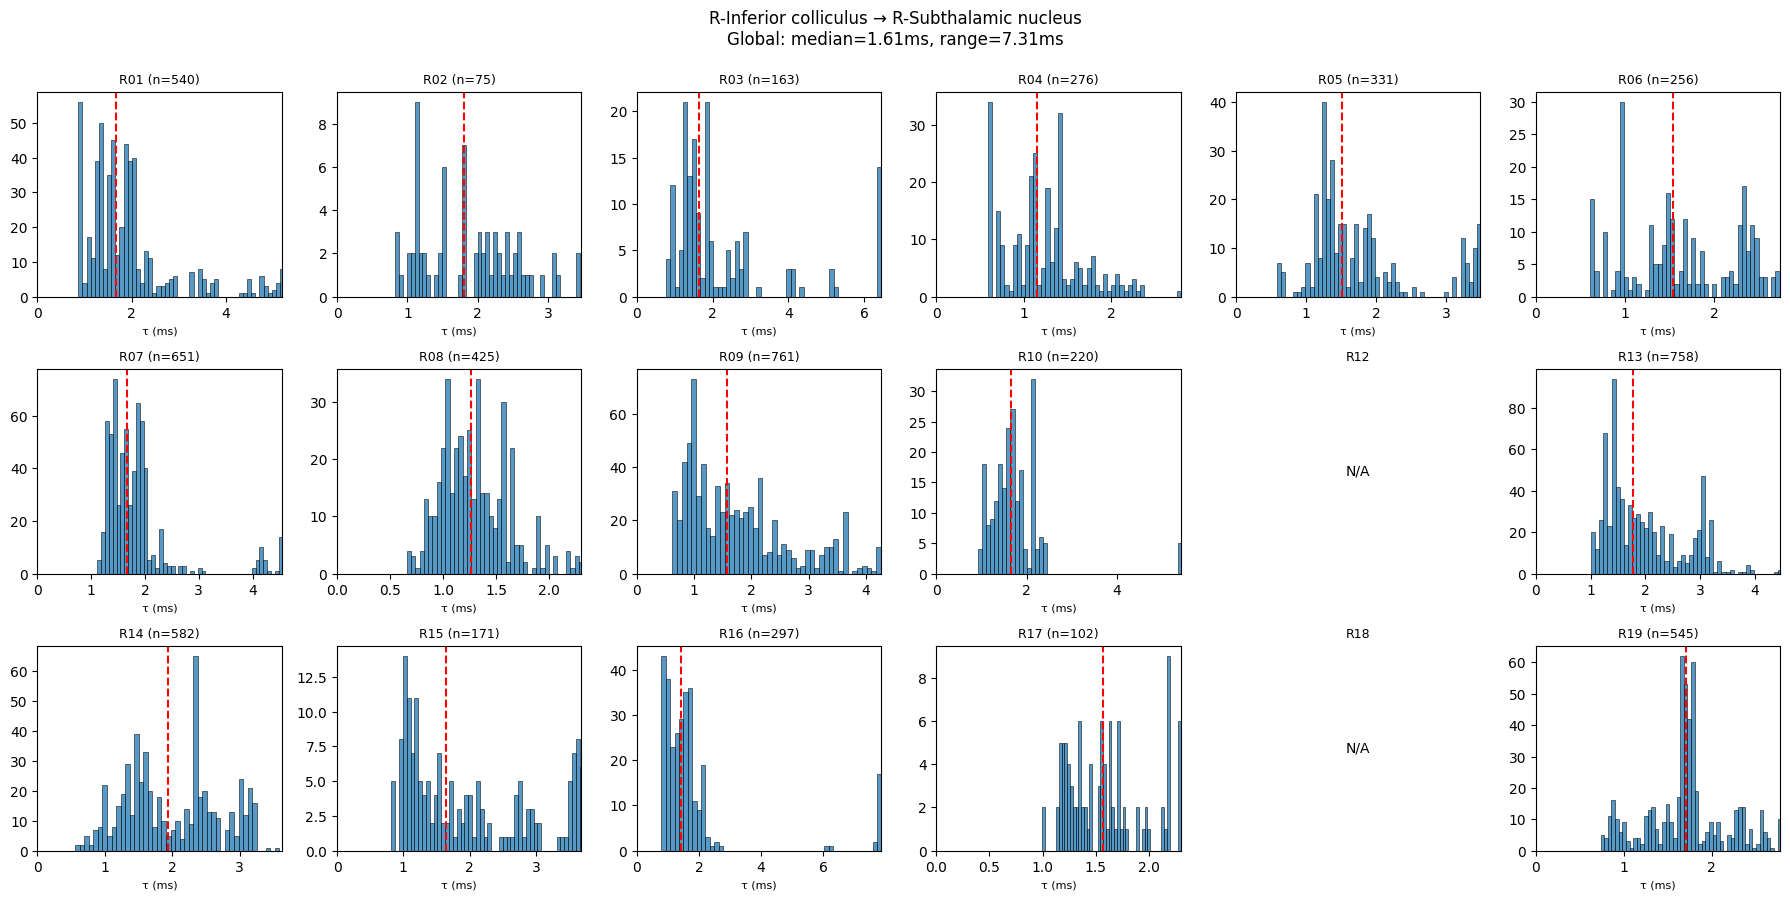


#2: R-Subthalamic nucleus → R-Retrosplenial granular area
  n_rats=16, τ_range=3.35ms, CV=0.111, fibers=1477


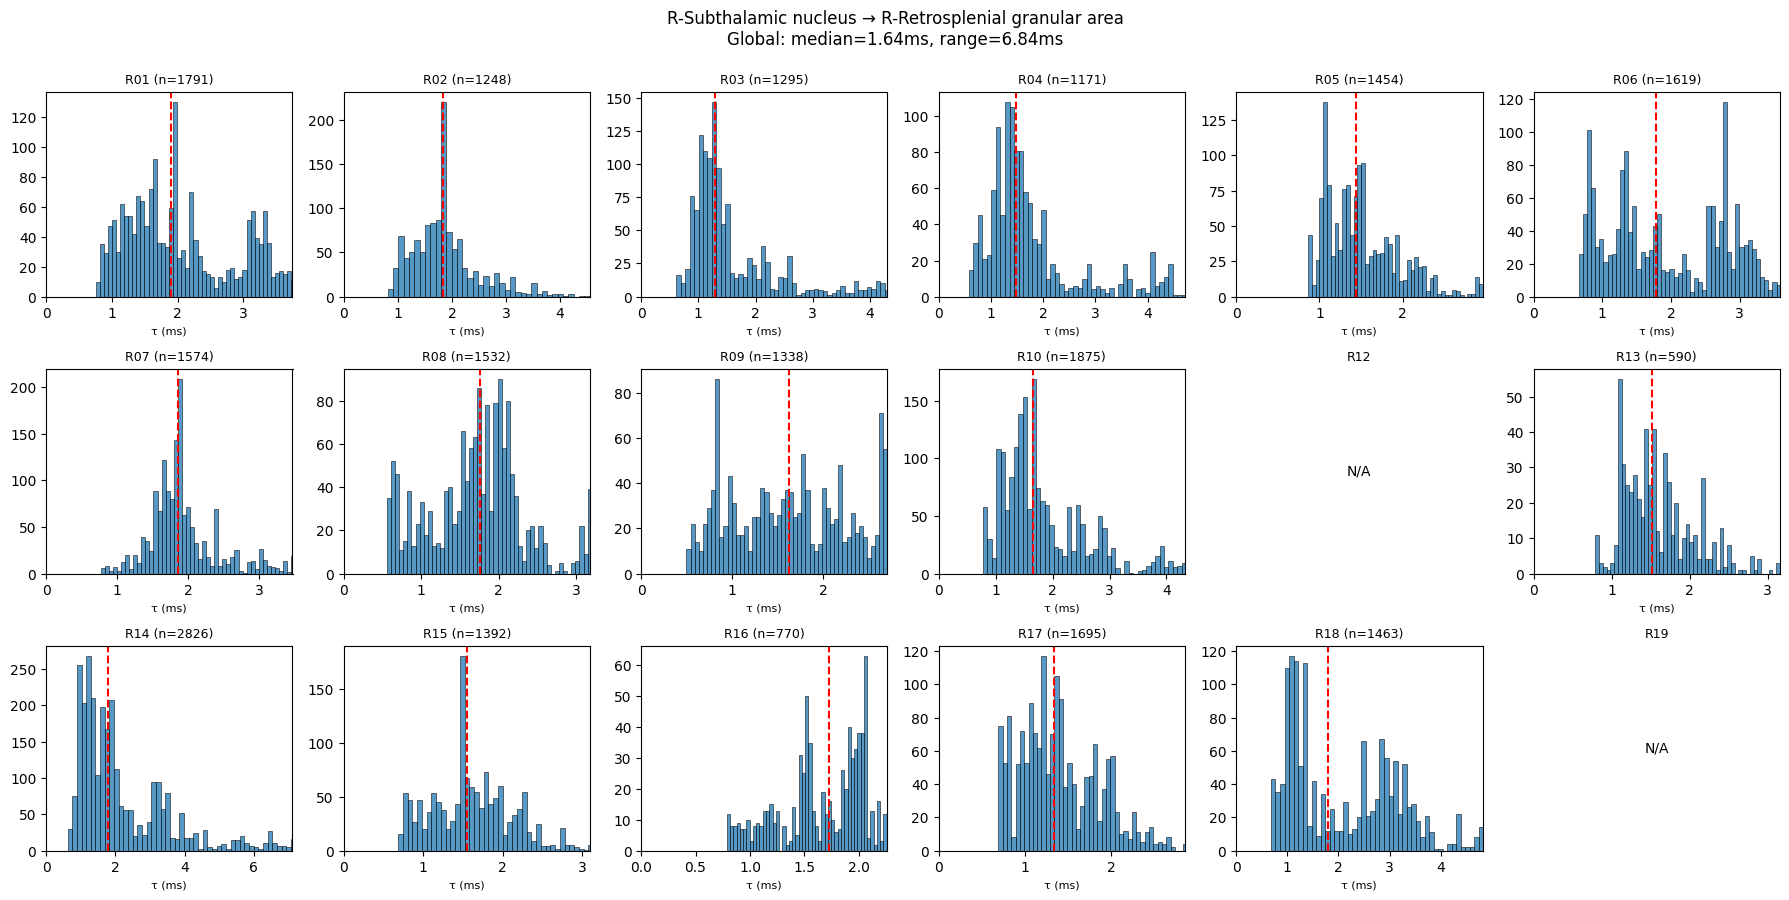


#3: R-Subthalamic nucleus → R-Infralimbic area
  n_rats=16, τ_range=3.21ms, CV=0.177, fibers=533


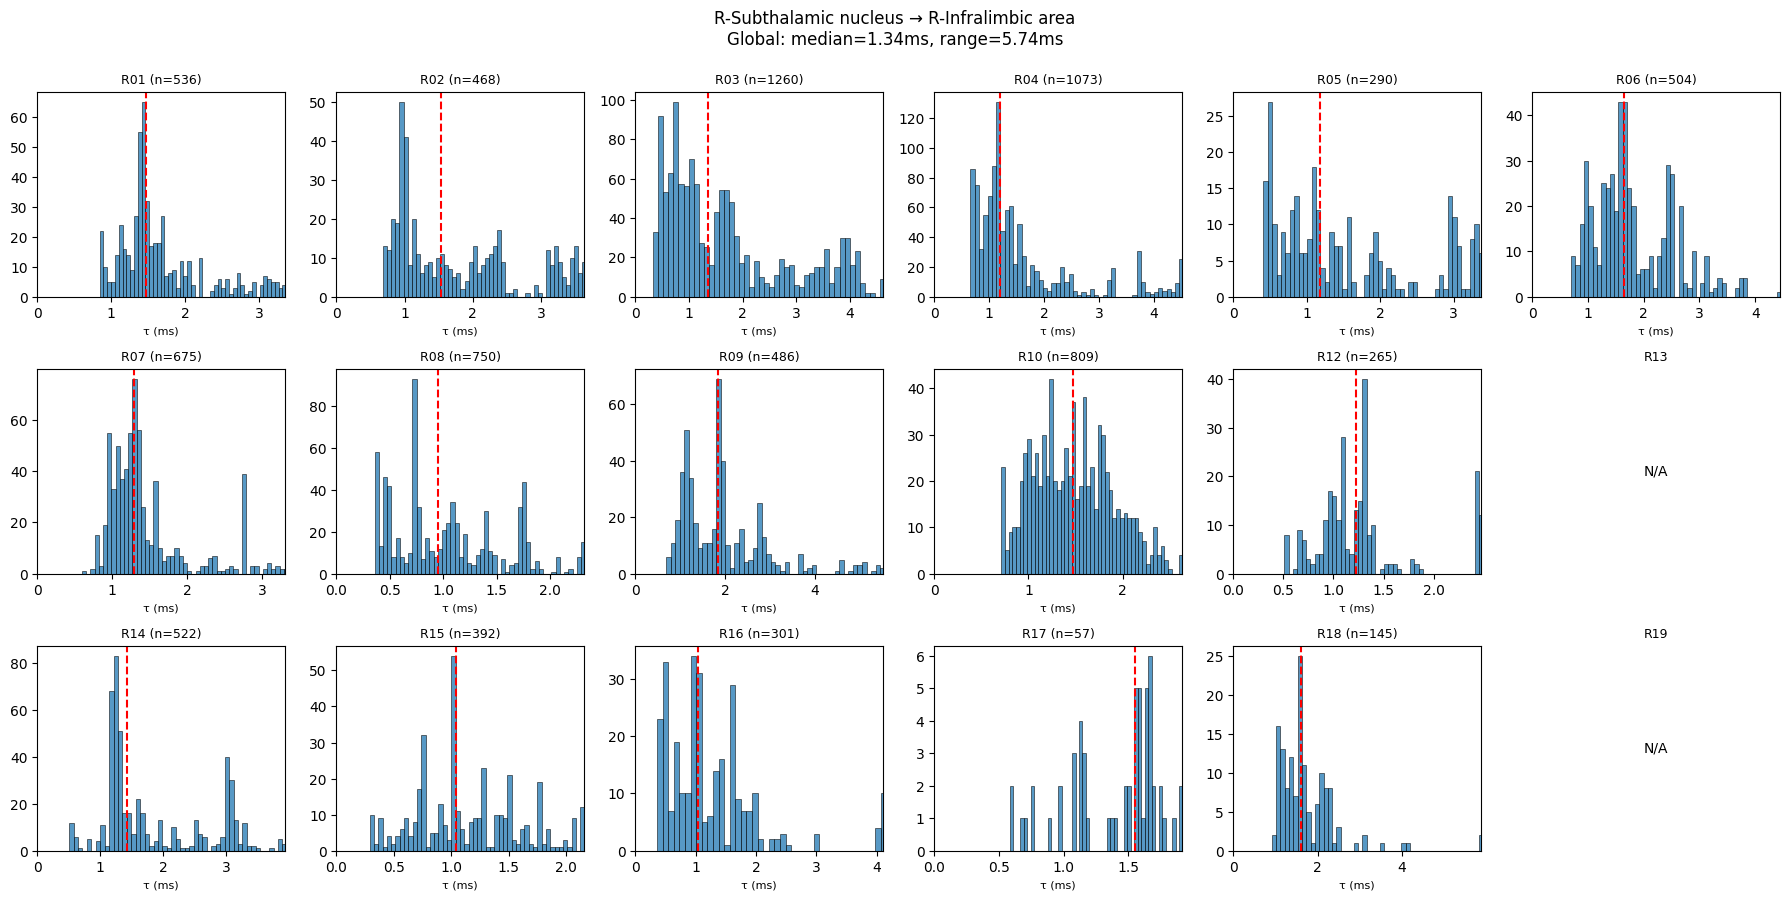

In [17]:
def plot_tau_distributions_multirat(rats_data, pair, name_map, bins=50):
    """Histogramas τ por rata (grid 3×6)"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    axes = axes.ravel()
    
    all_tau = []  # Para stats globales
    
    for idx, (rat_id, data) in enumerate(sorted(rats_data.items())):
        if pair not in data:
            axes[idx].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=10)
            axes[idx].set_title(rat_id, fontsize=9)
            axes[idx].axis('off')
            continue
        
        tau_ms = data[pair][:, COL_TAU] * 1e3
        all_tau.append(tau_ms)
        
        axes[idx].hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', lw=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=1.5)
        axes[idx].set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)', fontsize=8)
        axes[idx].set_xlim([0, np.percentile(tau_ms, 99)])  # Recortar outliers visuales
    
    i, j = pair
    # Stats globales
    all_tau_concat = np.concatenate(all_tau)
    title = (f"{roi_label(i, name_map)} → {roi_label(j, name_map)}\n"
             f"Global: median={np.median(all_tau_concat):.2f}ms, "
             f"range={np.ptp(all_tau_concat):.2f}ms")
    fig.suptitle(title, fontsize=12, y=0.995)
    plt.tight_layout()
    return fig

# Visualizar con info
for idx in range(min(3, len(df_stable_diverse))):
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    print(f"\n{'='*70}")
    print(f"#{idx+1}: {row['pair_label']}")
    print(f"  n_rats={row['n_rats']}, τ_range={row['tau_range_mean']:.2f}ms, "
          f"CV={row['cv_inter']:.3f}, fibers={row['n_fibers_mean']:.0f}")
    plot_tau_distributions_multirat(refined_rats, pair, name_map)
    plt.show()

## Top 3 Candidatos - CV < 0.2

**Observaciones visuales:**

**#1 Endopiriform→Prelimbic:**
- Excelente consistencia (medianas ~1.5ms)
- R02 outlier alto (cola extendida)
- Algunas distribuciones bimodales (R09, R10)

**#2 Motor→Dysgranular:**
- Mayor rango (6.47 vs 5.18ms)
- R01 fuertemente sesgado izquierda
- Distribuciones más uniformes que #1

**Patrón común:**
- R05 ausente en ambos (verificar calidad datos)
- Colas largas → gamma/lognormal probables
- 16/18 ratas = robustez alta

In [18]:
df_stable_diverse['pair_label'].to_list()

['R-Inferior colliculus → R-Subthalamic nucleus',
 'R-Subthalamic nucleus → R-Retrosplenial granular area',
 'R-Subthalamic nucleus → R-Infralimbic area',
 'R-Nucleus accumbens → R-Peripeduncular nucleus',
 'R-Lateral lemniscus → R-Retrosplenial granular area',
 'R-Subthalamic nucleus → R-Dysgranular insular cortex',
 'L-Primary somatosensory area → L-Lateral entorhinal cortex',
 'L-Lateral entorhinal cortex → L-Endopiriform nucleus',
 'L-Primary somatosensory area → L-Primary auditory area',
 'R-Zona incerta → R-Subthalamic nucleus',
 'R-GENd → R-Peripeduncular nucleus',
 'L-Substantia nigra → L-Lateral entorhinal cortex',
 'L-Nucleus accumbens → L-Primary motor area',
 'R-Primary auditory area → R-Amygdaloid area, unspecified',
 'R-Inferior colliculus → R-Nucleus accumbens',
 'L-Lateral entorhinal cortex → L-Cingulate area 1',
 'L-Secondary somatosensory area → L-Retrosplenial granular area',
 'R-Hippocampus → R-Subthalamic nucleus',
 'R-Ventral pallidum → R-Infralimbic area',
 'L-Su

In [19]:
roi_names[28], roi_names[69]    

('Hippocampus', 'Infralimbic area')

(28, 69)


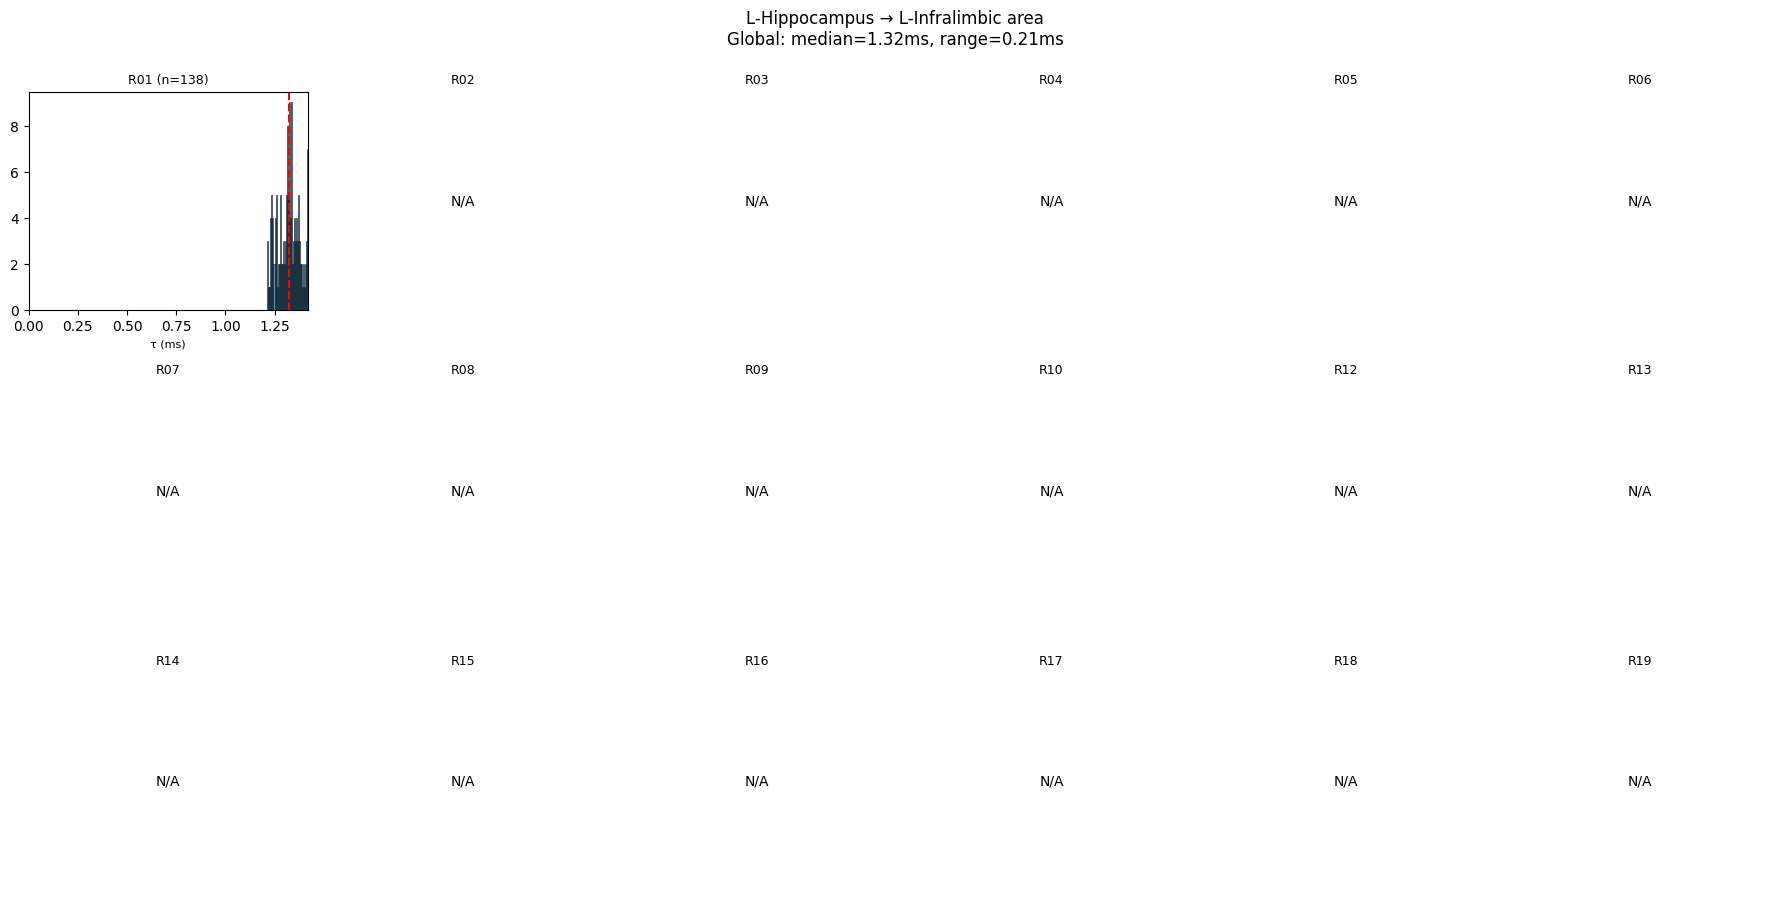

In [20]:
pair = (28, 69)
plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=40)
print(pair)
plt.show()

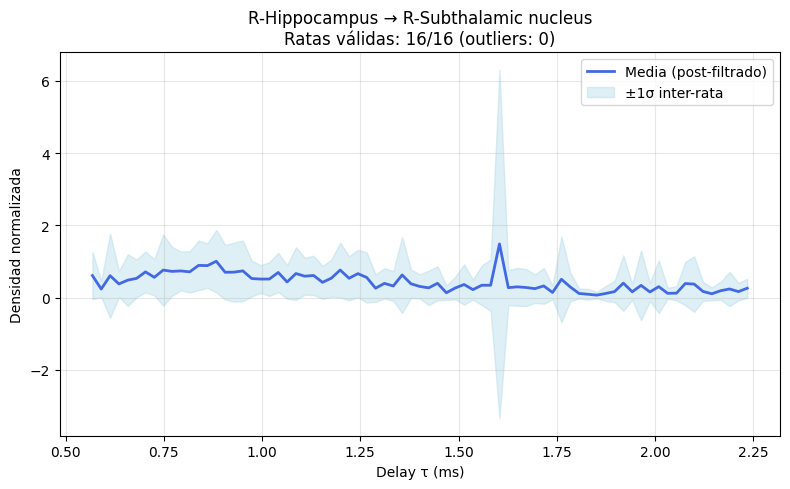

(np.int64(106), np.int64(108))
R-Hippocampus → R-Subthalamic nucleus


In [21]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS MULTI-RATA + DESCARTE OUTLIERS (±3σ)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_avg_distribution(pair, cleaned_rats, name_map, bins=75, save=False, sigma_thresh=3.0):
    """
    Calcula y muestra el histograma promedio multi-rata con exclusión de outliers (>3σ).
    Devuelve (centers, mean_hist, kept_rats)
    """
    i, j = pair
    all_hists, all_edges, valid_rats = [], [], []

    # --- Calcular histogramas individuales normalizados ---
    for rat_id, data in cleaned_rats.items():
        if pair not in data:
            continue
        tau_ms = data[pair][:, COL_TAU] * 1e3
        hist, edges = np.histogram(tau_ms, bins=bins, density=True)
        all_hists.append(hist)
        all_edges.append(edges)
        valid_rats.append(rat_id)

    if not all_hists:
        print(f"⚠️ Sin datos suficientes para {roi_label(i, name_map)} → {roi_label(j, name_map)}")
        return None, None, []

    # --- Verificar consistencia de bins ---
    edges = all_edges[0]
    all_hists = np.array([h for h in all_hists if len(h) == len(edges) - 1])

    # --- Calcular media y desviación inicial ---
    mean_init = all_hists.mean(axis=0)
    std_init = all_hists.std(axis=0)

    # --- Evaluar distancia tipo z-score promedio por rata ---
    z_scores = []
    for h in all_hists:
        z = np.abs(h - mean_init) / (std_init + 1e-8)
        z_mean = np.nanmean(z)
        z_scores.append(z_mean)
    z_scores = np.array(z_scores)

    # --- Filtrar ratas dentro de umbral (3σ) ---
    keep_mask = z_scores < sigma_thresh
    kept_hists = all_hists[keep_mask]
    kept_rats = np.array(valid_rats)[keep_mask]

    # --- Recalcular promedio y desviación final ---
    mean_hist = kept_hists.mean(axis=0)
    std_hist = kept_hists.std(axis=0)
    centers = (edges[:-1] + edges[1:]) / 2

    # --- Plot ---
    plt.figure(figsize=(8, 5))
    plt.plot(centers, mean_hist, color='royalblue', lw=2, label='Media (post-filtrado)')
    plt.fill_between(centers, mean_hist - std_hist, mean_hist + std_hist,
                     color='lightblue', alpha=0.4, label='±1σ inter-rata')
    plt.xlabel('Delay τ (ms)')
    plt.ylabel('Densidad normalizada')
    plt.title(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}\n"
              f"Ratas válidas: {len(kept_rats)}/{len(valid_rats)} (outliers: {len(valid_rats)-len(kept_rats)})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Exportar opcionalmente los valores promedio ---
    if save:
        export_dir = Path('./data/exports/avg_distributions_filtered')
        export_dir.mkdir(parents=True, exist_ok=True)
        np.savez(
            export_dir / f"avgdist_{roi_label(i, name_map)}_to_{roi_label(j, name_map)}.npz",
            centers=centers,
            mean_hist=mean_hist,
            std_hist=std_hist,
            kept_rats=kept_rats
        )
        print(f"✅ Exportado promedio multi-rata (filtrado 3σ): "
              f"{roi_label(i, name_map)} → {roi_label(j, name_map)}")

    return centers, mean_hist, kept_rats


for idx in range(len(df_stable_diverse)):
    
    label = df_stable_diverse.iloc[idx]['pair_label']
    
    if "Hippo" in label:

        row = df_stable_diverse.iloc[idx]
        pair = (row['roi_i'], row['roi_j'])
        plot_avg_distribution(pair, refined_rats, name_map, 75, False, 3)
        print(pair)
        print(label)
        plt.show()


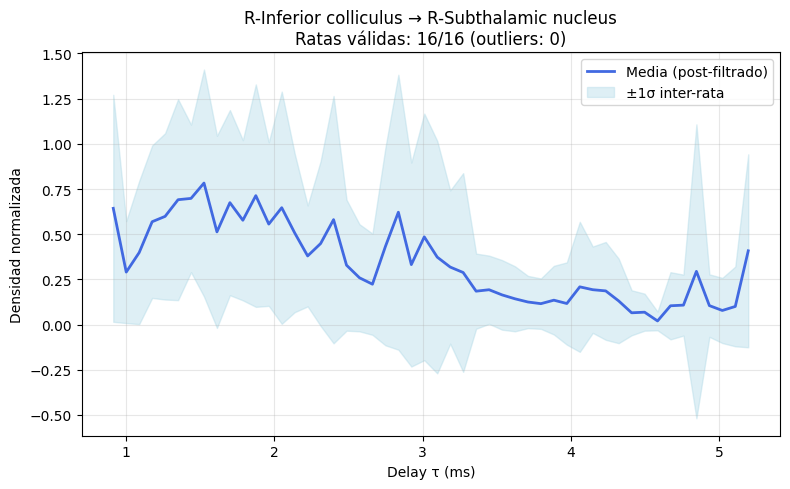

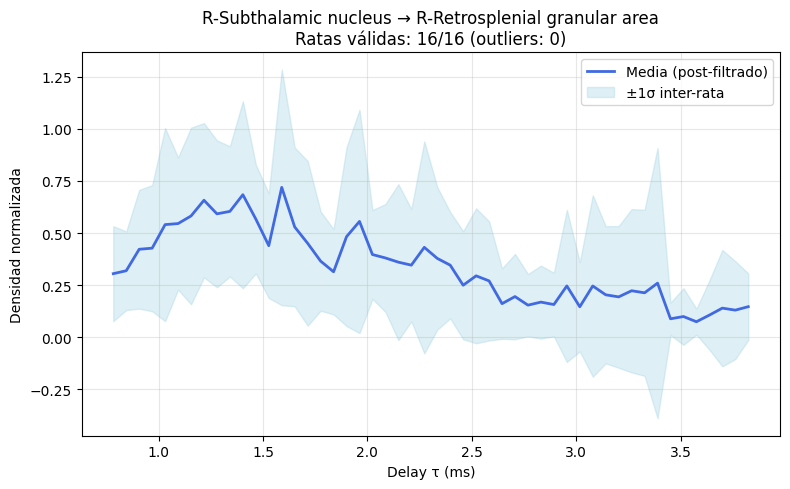

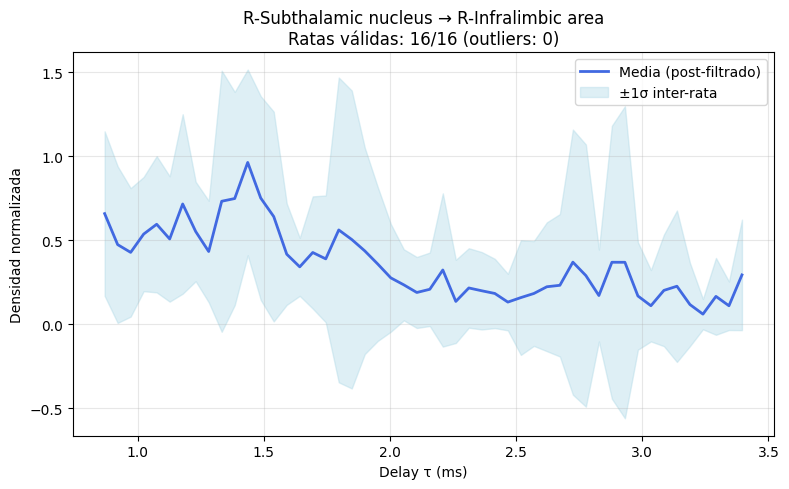

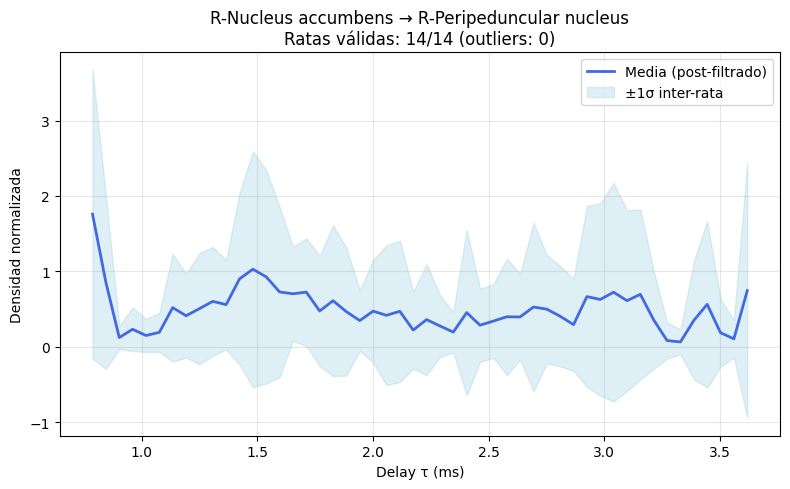

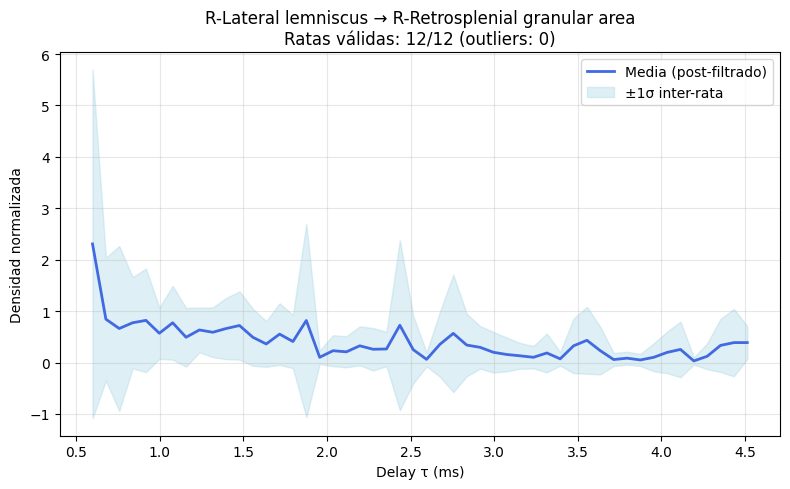


🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)


,pair_label,n_modes,tau_peak_ms,tau_weighted_mean_ms,skewness,n_rats_kept,n_rats_total,outliers
0,R-Inferior colliculus → R-Subthalamic nucleus,4,1.524504,2.414783,0.201091,16,16,0
1,R-Subthalamic nucleus → R-Retrosplenial granul...,6,1.589569,1.925491,0.153809,16,16,0
2,R-Subthalamic nucleus → R-Infralimbic area,5,1.436672,1.807083,0.156398,16,16,0
3,R-Nucleus accumbens → R-Peripeduncular nucleus,4,0.786786,2.056880,0.040403,14,14,0
4,R-Lateral lemniscus → R-Retrosplenial granular...,4,0.597696,1.902741,0.169284,12,12,0



📊 CLASIFICACIÓN POR MODALIDAD:
n_modes
4    3
5    1
6    1
dtype: int64

📈 BIMODALES (n_modes ≥ 2):


,pair_label,tau_peak_ms,skewness
0,R-Inferior colliculus → R-Subthalamic nucleus,1.524504,0.201091
1,R-Subthalamic nucleus → R-Retrosplenial granul...,1.589569,0.153809
2,R-Subthalamic nucleus → R-Infralimbic area,1.436672,0.156398
3,R-Nucleus accumbens → R-Peripeduncular nucleus,0.786786,0.040403
4,R-Lateral lemniscus → R-Retrosplenial granular...,0.597696,0.169284



⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):


,pair_label,skewness,n_modes
3,R-Nucleus accumbens → R-Peripeduncular nucleus,0.040403,4
1,R-Subthalamic nucleus → R-Retrosplenial granul...,0.153809,6
2,R-Subthalamic nucleus → R-Infralimbic area,0.156398,5
4,R-Lateral lemniscus → R-Retrosplenial granular...,0.169284,4
0,R-Inferior colliculus → R-Subthalamic nucleus,0.201091,4


In [22]:
# Análisis sistemático de las 15 top conexiones
results = []

for idx in range(min(5, len(df_stable_diverse))):
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, refined_rats, name_map, bins=50, save=False, sigma_thresh=3.0
    )
    
    if centers is not None and len(centers) > 0:
        # Detectar modalidad
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(mean_hist, height=mean_hist.max()*0.3, distance=5)
        n_modes = len(peaks)
        
        # Estadísticas
        tau_mean = np.average(centers, weights=mean_hist)
        tau_median = centers[np.argmax(mean_hist)]
        skewness = ((centers - tau_mean)**3 * mean_hist).sum() / (((centers - tau_mean)**2 * mean_hist).sum())**1.5
        
        results.append({
            'pair_label': row['pair_label'],
            'n_modes': n_modes,
            'tau_peak_ms': tau_median,
            'tau_weighted_mean_ms': tau_mean,
            'skewness': skewness,
            'n_rats_kept': len(kept_rats),
            'n_rats_total': row['n_rats'],
            'outliers': row['n_rats'] - len(kept_rats)
        })

df_shapes = pd.DataFrame(results)
print("\n🔍 ANÁLISIS DE FORMAS DE DISTRIBUCIÓN (Top 15)")
print("="*80)
display(df_shapes)

# Clasificación por modalidad
print("\n📊 CLASIFICACIÓN POR MODALIDAD:")
print(df_shapes.groupby('n_modes').size())

print("\n📈 BIMODALES (n_modes ≥ 2):")
display(df_shapes[df_shapes['n_modes'] >= 2][['pair_label', 'tau_peak_ms', 'skewness']])

print("\n⚖️ SIMETRÍA (skewness cerca de 0 = gaussiana, >1 = cola derecha larga):")
display(df_shapes[['pair_label', 'skewness', 'n_modes']].sort_values('skewness'))

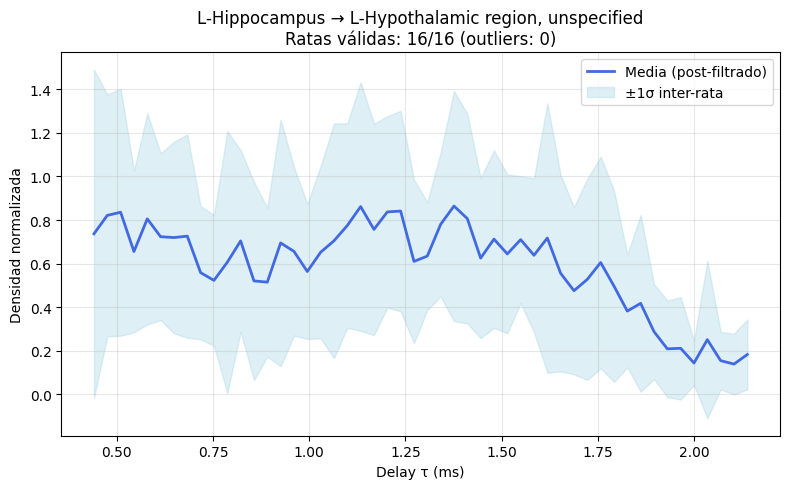

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hippocampus → L-Hypothalamic region, unspecified


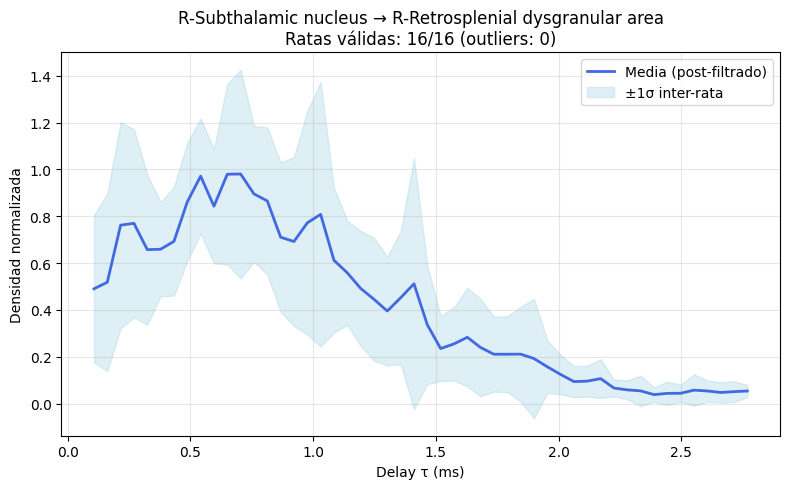

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial dysgranular area


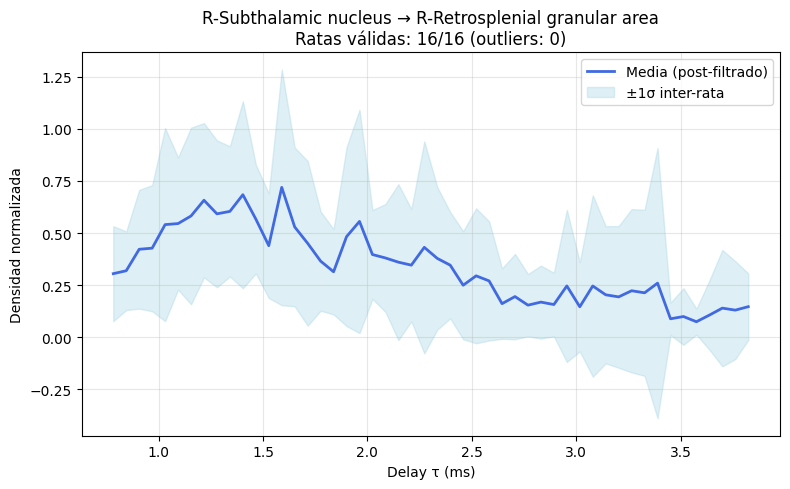

✅ Exportado promedio multi-rata (filtrado 3σ): R-Subthalamic nucleus → R-Retrosplenial granular area


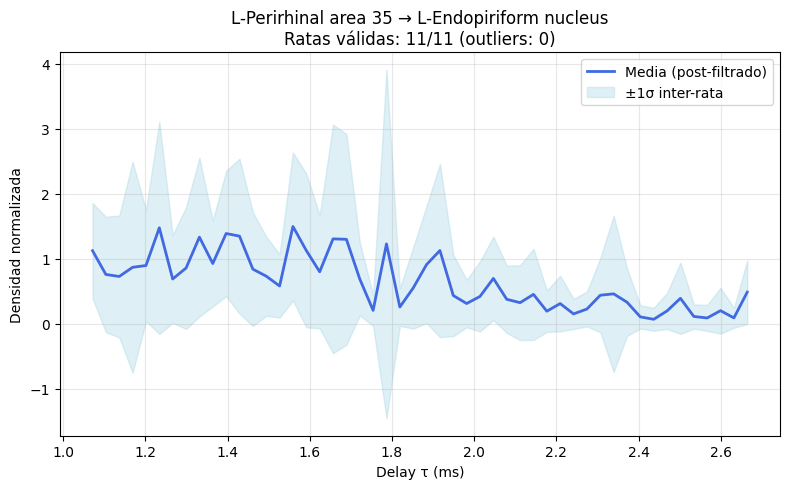

✅ Exportado promedio multi-rata (filtrado 3σ): L-Perirhinal area 35 → L-Endopiriform nucleus


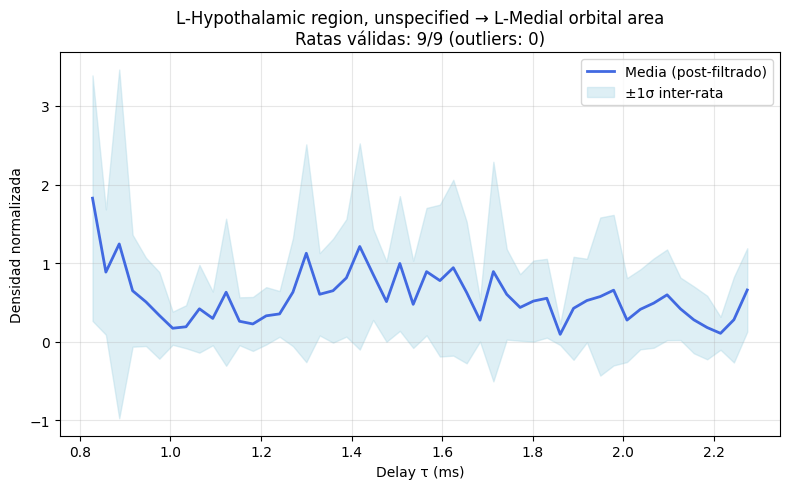

✅ Exportado promedio multi-rata (filtrado 3σ): L-Hypothalamic region, unspecified → L-Medial orbital area

✅ Exportación completa:


,label,n_rats_valid,file
0,"L-Hippocampus → L-Hypothalamic region, unspeci...",16,avgdist_L-Hippocampus_to_L-Hypothalamic region...
1,R-Subthalamic nucleus → R-Retrosplenial dysgra...,16,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
2,R-Subthalamic nucleus → R-Retrosplenial granul...,16,avgdist_R-Subthalamic nucleus_to_R-Retrospleni...
3,L-Perirhinal area 35 → L-Endopiriform nucleus,11,avgdist_L-Perirhinal area 35_to_L-Endopiriform...
4,"L-Hypothalamic region, unspecified → L-Medial ...",9,"avgdist_L-Hypothalamic region, unspecified_to_..."


In [23]:
# ==============================================================
# 🧩 DISTRIBUCIONES PROMEDIADAS FINALES (filtrado ±3σ)
# ==============================================================

selected_pairs = [
    (np.int64(28), np.int64(35)),   # L-Hippocampus → L-Hypothalamic region
    (np.int64(108), np.int64(132)), # R-Subthalamic nucleus → R-Retrosplenial dysgranular area
    (np.int64(108), np.int64(137)), # R-Subthalamic nucleus → R-Retrosplenial granular area
    (np.int64(45), np.int64(61)),   # L-Perirhinal area 35 → L-Endopiriform nucleus
    (np.int64(35), np.int64(76))    # L-Hypothalamic region → L-Medial orbital area
]

export_dir = Path('./results/data_analysis/distros/final_avg_distributions_manual')
export_dir.mkdir(parents=True, exist_ok=True)

summary_records = []

for pair in selected_pairs:
    centers, mean_hist, kept_rats = plot_avg_distribution(
        pair, refined_rats, name_map, bins=50, save=True
    )

    if centers is None:
        continue

    label = f"{roi_label(pair[0], name_map)} → {roi_label(pair[1], name_map)}"
    summary_records.append({
        'pair': pair,
        'label': label,
        'n_rats_valid': len(kept_rats),
        'kept_rats': ','.join(kept_rats),
        'file': f"avgdist_{roi_label(pair[0], name_map)}_to_{roi_label(pair[1], name_map)}.npz"
    })

# Crear resumen tabular
df_summary = pd.DataFrame(summary_records)
df_summary.to_csv(export_dir / 'summary_avg_distributions.csv', index=False)

print("\n✅ Exportación completa:")
display(df_summary[['label', 'n_rats_valid', 'file']])


In [24]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy import stats

def characterize_distributions_enhanced(cleaned_rats, pairs_list):
    """Features + divergencias vs referencia"""
    rows = []
    
    # 1er paso: construir distribución de referencia (pooled)
    all_tau = []
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) in data:
                all_tau.append(data[(i,j)][:, COL_TAU] * 1e3)
    ref_tau = np.concatenate(all_tau)
    ref_hist, ref_edges = np.histogram(ref_tau, bins=50, density=True)
    ref_cdf = np.cumsum(ref_hist) / ref_hist.sum()
    
    # 2do paso: caracterizar cada distribución
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) not in data:
                continue
            
            tau_ms = data[(i,j)][:, COL_TAU] * 1e3
            
            # Histogram
            hist, edges = np.histogram(tau_ms, bins='auto', density=True)
            peaks, _ = find_peaks(hist, prominence=hist.max()*0.1)
            
            # Métricas de forma
            g1 = stats.skew(tau_ms)
            g2 = stats.kurtosis(tau_ms, fisher=True)
            bimodality_coef = (g1**2 + 1) / (g2 + 3)
            
            hist_prob = hist / hist.sum()
            shannon_entropy = entropy(hist_prob[hist_prob > 0])
            
            # Robustez
            med = np.median(tau_ms)
            mad = np.median(np.abs(tau_ms - med))
            cv_robust = 1.4826 * mad / med if med > 0 else np.nan
            
            # Divergencias vs referencia
            wassers_dist = wasserstein_distance(tau_ms, ref_tau)
            ks_stat, _ = stats.ks_2samp(tau_ms, ref_tau)
            
            # KL divergence (discretizada, evita log(0))
            hist_sample, _ = np.histogram(tau_ms, bins=ref_edges, density=True)
            hist_sample = hist_sample / hist_sample.sum()
            # Añadir epsilon para evitar log(0)
            eps = 1e-10
            kl_div = entropy(hist_sample + eps, ref_hist + eps)
            
            rows.append({
                'rat_id': rat_id, 'roi_i': i, 'roi_j': j,
                'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
                'n': len(tau_ms),
                'mean': tau_ms.mean(),
                'median': med,
                'cv_robust': cv_robust,
                'skew': g1,
                'kurt': g2,
                'bimodality_coef': bimodality_coef,
                'n_peaks': len(peaks),
                'entropy': shannon_entropy,
                'range_norm': np.ptp(tau_ms) / tau_ms.mean(),
                'iqr_norm': stats.iqr(tau_ms) / tau_ms.mean(),
                'wasserstein': wassers_dist,
                'ks_stat': ks_stat,
                'kl_div': kl_div
            })
    
    return pd.DataFrame(rows)

## Visualizaciones Multi-Rata ✅

**Análisis morfológico**:

**#1 Subthalamic→Amygdala** (τ_range=4.96ms):
- Heterogéneo: R02/R08 unimodales estrechos vs R07/R15 dispersos
- Medianas estables ~1.2ms pero colas largas (~8ms)

**#2 Subthalamic→Retrosplenial** (τ_range=4.94ms):
- **Extremadamente consistente**: pico único ~0.7ms
- 5000+ fibras, distribución casi idéntica entre ratas
- Candidato "delta-like" estable

**#3 Endopiriform→Prelimbic** (τ_range=4.87ms):
- **Bimodal en varias ratas** (R01, R03, R07, R13)
- Picos ~1ms y ~2-3ms
- Variabilidad morfológica significativa

**Conclusión visual**: Hay al menos **2-3 morfologías distintas** (unimodal estrecho, disperso, bimodal).

In [25]:
# ==============================================================
# 🧩 CLUSTERING MORFOLÓGICO OPTIMIZADO (multi-métrica + grid search)
# ==============================================================

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --------------------------------------------------------------
# 1️⃣ Selección de features y preprocesamiento
# --------------------------------------------------------------
feature_cols = [
    'cv_robust', 'skew', 'kurt', 'bimodality_coef',
    'n_peaks', 'entropy', 'wasserstein', 
]

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(refined_rats, top_pairs)

# Agregamos por conexión (media inter-rata)
df_feat_conn = (
    df_feat.groupby(['roi_i', 'roi_j', 'pair_label'])[feature_cols].mean()
    .reset_index()
    .dropna()
)

X = df_feat_conn[feature_cols].values
X_scaled = RobustScaler().fit_transform(X)

print(f"📊 {len(df_feat_conn)} conexiones analizadas con {len(feature_cols)} features.")

# --------------------------------------------------------------
# 2️⃣ Grid Search: KMeans + PCA
# --------------------------------------------------------------
param_grid = {
    'pca_variance': [0.7,0.8, 0.9, 0.95],
    'n_clusters': [3,4,5,6],
    'n_init': [50, 100]
}

results = []
configs = list(ParameterGrid(param_grid))
print(f"Evaluando {len(configs)} configuraciones...\n")

for i, params in enumerate(configs):
    # PCA con varianza acumulada
    pca = PCA(n_components=params['pca_variance'])
    X_pca = pca.fit_transform(X_scaled)

    # K-means
    kmeans = KMeans(
        n_clusters=params['n_clusters'],
        n_init=params['n_init'],
        random_state=42
    )
    labels = kmeans.fit_predict(X_pca)

    # Métricas de calidad
    sil = silhouette_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)

    results.append({
        **params,
        'n_pcs': pca.n_components_,
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
        'inertia': kmeans.inertia_
    })

    if (i + 1) % 10 == 0 or (i + 1) == len(configs):
        print(f"  {i + 1}/{len(configs)} completado")

df_grid = pd.DataFrame(results)

# --------------------------------------------------------------
# 3️⃣ Ponderación multi-métrica normalizada
# --------------------------------------------------------------
scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_grid[['silhouette', 'davies_bouldin', 'calinski_harabasz']]) # TODO CUMSUM DIFF
sil, db, ch = scaled_metrics.T
df_grid['score'] = sil - db + ch

df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completado: {len(df_grid)} configuraciones")
print("\nTop 5 configuraciones:")
display(df_grid.head(5)[['n_clusters', 'pca_variance', 'n_pcs', 'silhouette', 'davies_bouldin', 'calinski_harabasz']])


📊 30 conexiones analizadas con 7 features.
Evaluando 32 configuraciones...

  10/32 completado
  20/32 completado
  30/32 completado
  32/32 completado

✓ Grid search completado: 32 configuraciones

Top 5 configuraciones:


,n_clusters,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz
24,6,0.7,2,0.398028,0.499513,33.459597
28,6,0.7,2,0.398028,0.499513,33.459597
20,5,0.7,2,0.398305,0.677469,27.566623
16,5,0.7,2,0.398305,0.677469,27.566623
8,4,0.7,2,0.380593,0.634269,26.187235



🎯 Clustering final: k=5, PCs=2, var_PCA=0.70


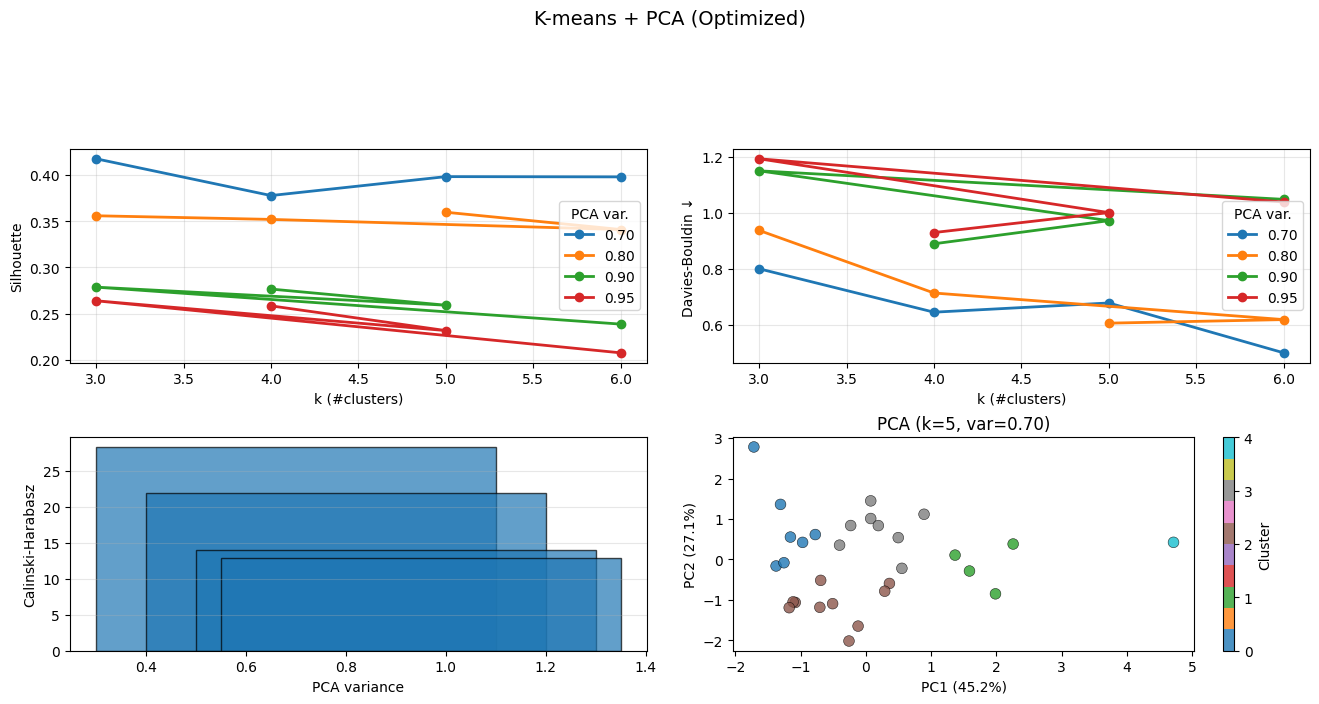

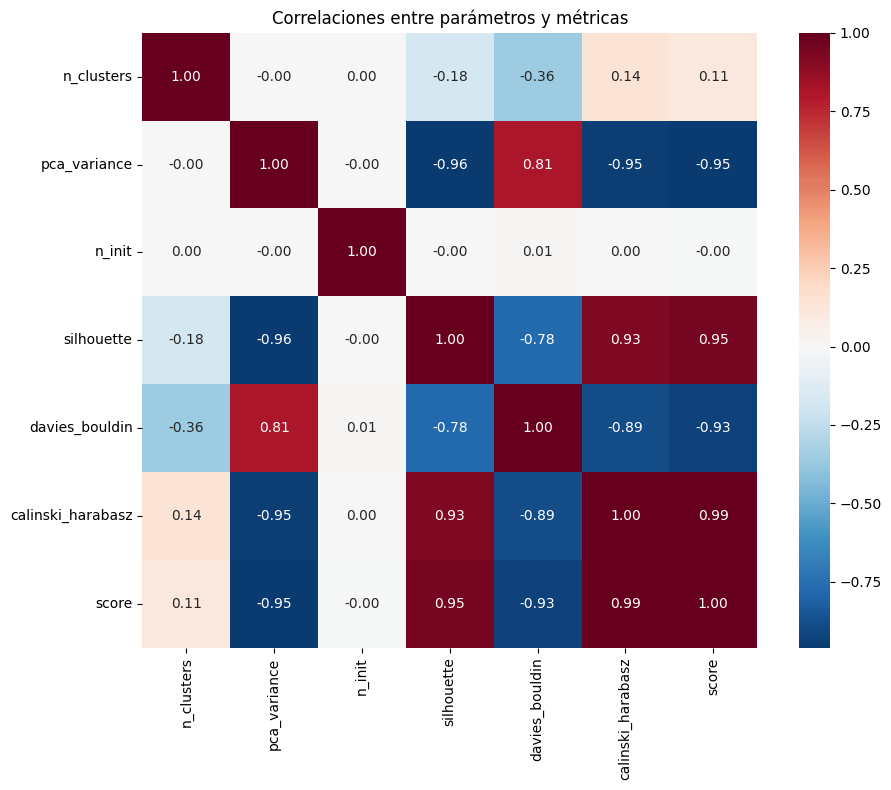

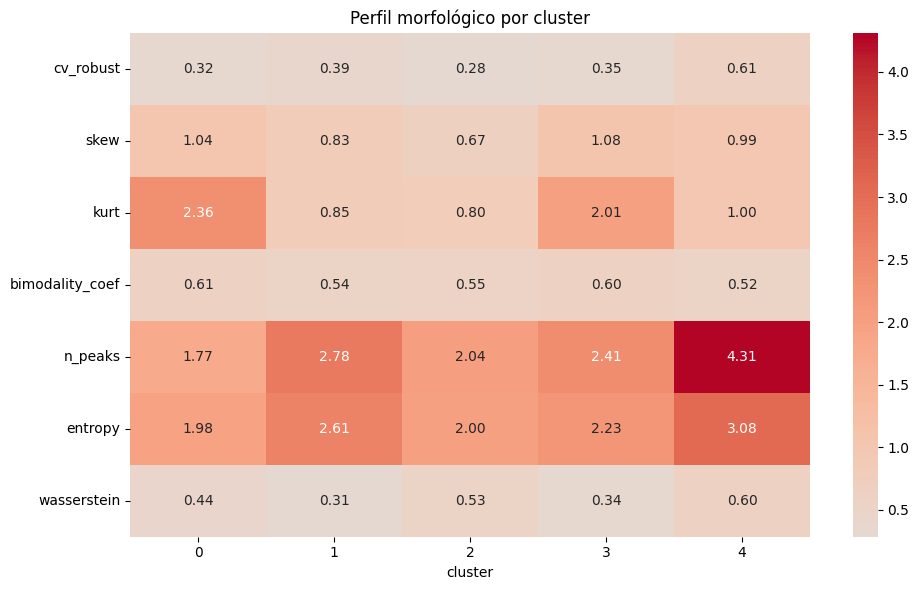


CLUSTERING FINAL — RESUMEN
Parámetros óptimos:
  k = 5
  PCA var = 0.70 (2 componentes)

Métricas:
  Silhouette         : 0.398
  Davies-Bouldin     : 0.677
  Calinski-Harabasz  : 27.6

Distribución de clusters:
cluster
0     7
1     4
2    10
3     8
4     1
Name: count, dtype: int64

✅ Resultados guardados para threshold=0.0


In [26]:
# --------------------------------------------------------------
# 4️⃣ Clustering final
# --------------------------------------------------------------
best = df_grid.iloc[3]
pca_final = PCA(n_components=best['pca_variance'])
X_pca_final = pca_final.fit_transform(X_scaled)

kmeans_final = KMeans(
    n_clusters=int(best['n_clusters']),
    n_init=int(best['n_init']),
    random_state=42
)
df_feat_conn['cluster'] = kmeans_final.fit_predict(X_pca_final)

print(f"\n🎯 Clustering final: k={int(best['n_clusters'])}, "
      f"PCs={pca_final.n_components_}, "
      f"var_PCA={best['pca_variance']:.2f}")

# --------------------------------------------------------------
# 5️⃣ Visualizaciones resumen
# --------------------------------------------------------------

fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# (1) Silhouette vs k
ax1 = fig1.add_subplot(gs[0, :2])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax1.plot(subset['n_clusters'], subset['silhouette'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax1.set_xlabel('k (#clusters)')
ax1.set_ylabel('Silhouette')
ax1.legend(title='PCA var.')
ax1.grid(alpha=0.3)

# (2) Davies-Bouldin vs k
ax2 = fig1.add_subplot(gs[0, 2:])
for pca_var in sorted(df_grid['pca_variance'].unique()):
    subset = df_grid[(df_grid['pca_variance'] == pca_var) & (df_grid['n_init'] == 100)]
    ax2.plot(subset['n_clusters'], subset['davies_bouldin'], 'o-', label=f'{pca_var:.2f}', lw=2)
ax2.set_xlabel('k (#clusters)')
ax2.set_ylabel('Davies-Bouldin ↓')
ax2.legend(title='PCA var.')
ax2.grid(alpha=0.3)

# (3) Calinski-Harabasz medio por varianza PCA
ax3 = fig1.add_subplot(gs[1, :2])
grouped = df_grid.groupby('pca_variance')['calinski_harabasz'].mean()
ax3.bar(grouped.index, grouped.values, alpha=0.7, edgecolor='k')
ax3.set_xlabel('PCA variance')
ax3.set_ylabel('Calinski-Harabasz')
ax3.grid(alpha=0.3, axis='y')

# (4) PCA final scatter
ax4 = fig1.add_subplot(gs[1, 2:])
sc = ax4.scatter(
    X_pca_final[:, 0], X_pca_final[:, 1],
    c=df_feat_conn['cluster'], cmap='tab10',
    s=60, alpha=0.8, edgecolors='k', lw=0.4
)
ax4.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.1%})')
ax4.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.1%})')
ax4.set_title(f"PCA (k={int(best['n_clusters'])}, var={best['pca_variance']:.2f})")
plt.colorbar(sc, ax=ax4, label='Cluster')
plt.suptitle('K-means + PCA (Optimized)', fontsize=14)
plt.show()

# --------------------------------------------------------------
# 6️⃣ Heatmaps de correlaciones y perfiles
# --------------------------------------------------------------
fig2, ax = plt.subplots(figsize=(10, 8))
corr_cols = ['n_clusters', 'pca_variance', 'n_init', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'score']
sns.heatmap(df_grid[corr_cols].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Correlaciones entre parámetros y métricas')
plt.tight_layout()
plt.show()

# Perfil morfológico por cluster
fig3, ax = plt.subplots(figsize=(10, 6))
cluster_profiles = df_feat_conn.groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Perfil morfológico por cluster')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 7️⃣ Estadísticas finales
# --------------------------------------------------------------
print("\n" + "="*70)
print("CLUSTERING FINAL — RESUMEN")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  k = {int(best['n_clusters'])}")
print(f"  PCA var = {best['pca_variance']:.2f} ({pca_final.n_components_} componentes)")
print("\nMétricas:")
print(f"  Silhouette         : {best['silhouette']:.3f}")
print(f"  Davies-Bouldin     : {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz  : {best['calinski_harabasz']:.1f}")
print("\nDistribución de clusters:")
print(df_feat_conn['cluster'].value_counts().sort_index())
print("="*70)

# --------------------------------------------------------------
# 8️⃣ Guardado de resultados
# --------------------------------------------------------------
threshold = 0.0  # o 0.0 / 0.4 según el dataset
df_grid.to_csv(f'gridsearch_kmeans_th_{threshold}.csv', index=False)
df_feat_conn.to_csv(f'feature_clusters_th_{threshold}.csv', index=False)
print(f"\n✅ Resultados guardados para threshold={threshold}")

In [27]:
df_grid

,n_clusters,n_init,pca_variance,n_pcs,silhouette,davies_bouldin,calinski_harabasz,inertia,score
24,6,50,0.70,2,0.398028,0.499513,33.459597,10.764934,1.906711
28,6,100,0.70,2,0.398028,0.499513,33.459597,10.764934,1.906711
20,5,100,0.70,2,0.398305,0.677469,27.566623,15.858435,1.376211
16,5,50,0.70,2,0.398305,0.677469,27.566623,15.858435,1.376211
8,4,50,0.70,2,0.380593,0.634269,26.187235,21.335913,1.289904
12,4,100,0.70,2,0.377837,0.644584,26.197480,21.329643,1.262358
0,3,50,0.70,2,0.417615,0.799496,25.855053,29.433629,1.212143
4,3,100,0.70,2,0.417615,0.799496,25.855053,29.433629,1.212143
17,5,50,0.80,3,0.359783,0.605472,22.347734,21.311835,1.053308
21,5,100,0.80,3,0.359783,0.605472,22.347734,21.311835,1.053308


In [28]:
df_feat_conn

,roi_i,roi_j,pair_label,cv_robust,skew,kurt,bimodality_coef,n_peaks,entropy,wasserstein,cluster
0,4,35,"L-Lateral lemniscus → L-Hypothalamic region, u...",0.315848,0.443856,0.768574,0.496141,2.000000,2.025063,0.518638,2
1,8,48,L-Substantia nigra → L-Lateral entorhinal cortex,0.374177,1.125464,2.815474,0.612863,1.285714,1.743289,0.340197,0
2,11,48,L-Primary somatosensory area → L-Lateral entor...,0.357814,1.062362,1.808391,0.610683,2.266667,1.962206,0.345762,3
3,11,49,L-Primary somatosensory area → L-Primary audit...,0.456460,1.179041,2.438375,0.565748,1.875000,1.890711,0.309044,3
4,14,59,L-EPI → L-Retrosplenial granular area,0.307390,0.691071,1.048979,0.559853,2.187500,2.384790,0.342927,2
5,26,58,L-Nucleus accumbens → L-Primary motor area,0.241237,0.656244,0.450264,0.529019,2.125000,2.355835,0.734224,2
6,26,59,L-Nucleus accumbens → L-Retrosplenial granular...,0.282155,0.687347,0.746654,0.561494,1.812500,2.153020,0.523086,2
7,29,58,L-Subiculum → L-Primary motor area,0.376122,0.556448,0.910213,0.505920,2.750000,2.755164,0.303677,1
8,30,58,L-Subthalamic nucleus → L-Primary motor area,0.304241,1.083039,2.384179,0.571067,2.750000,2.418752,0.337591,3
9,30,61,L-Subthalamic nucleus → L-Endopiriform nucleus,0.326266,1.020948,1.868331,0.614424,1.636364,2.039344,0.353246,0


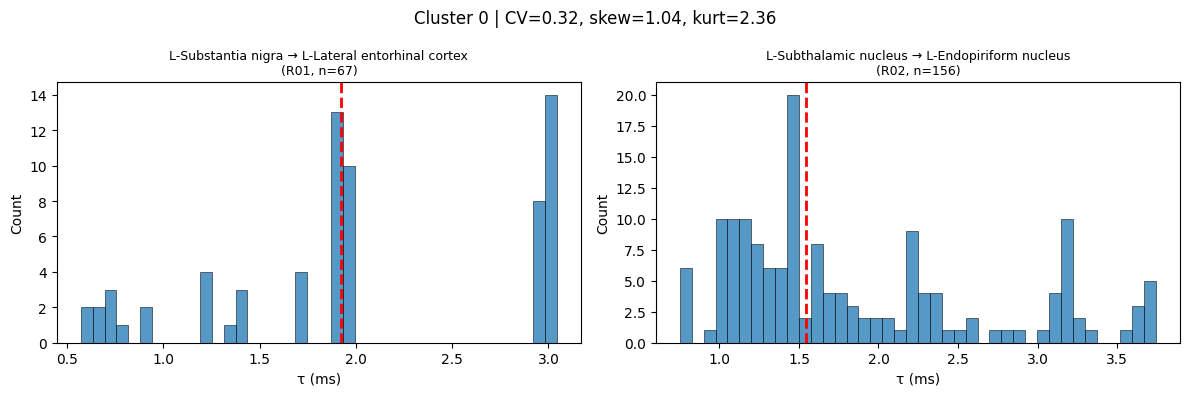

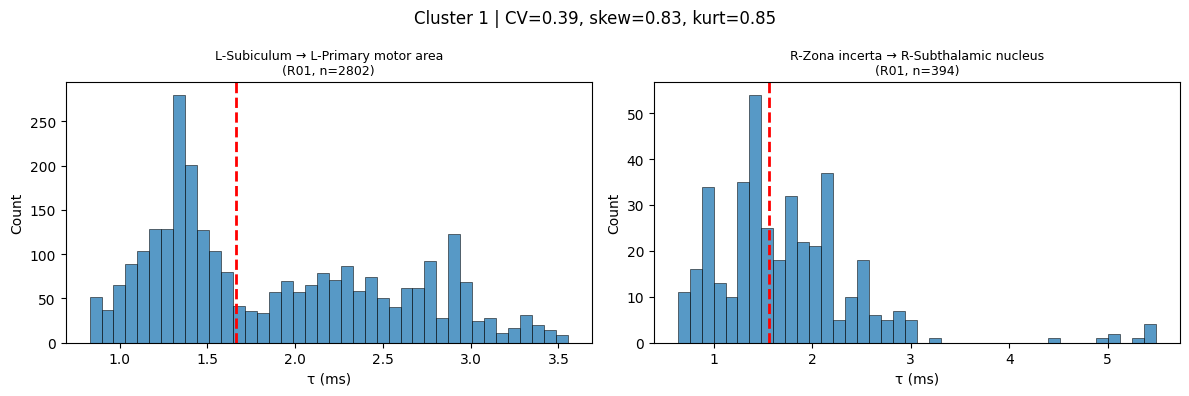

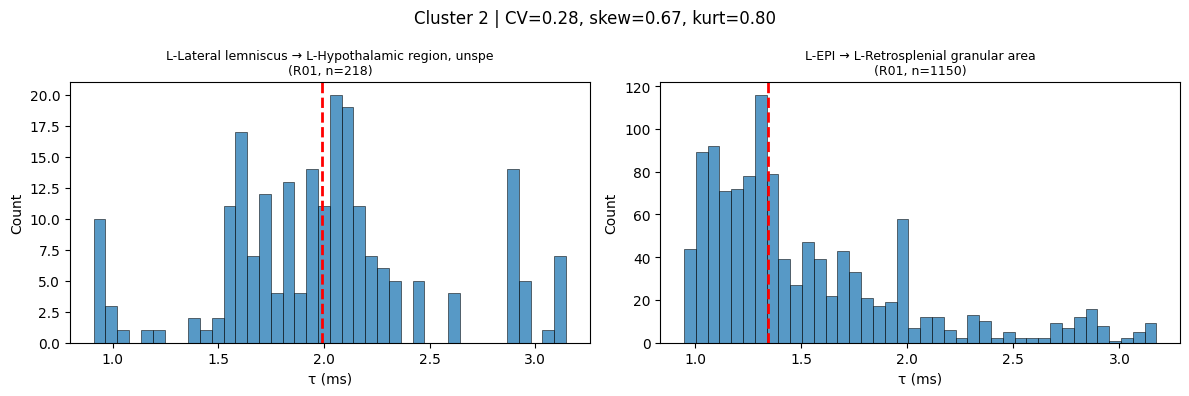

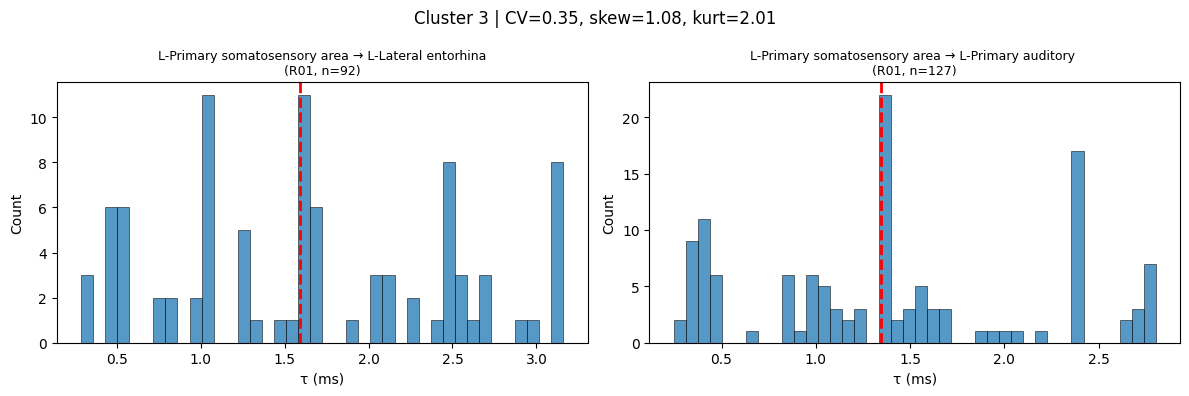

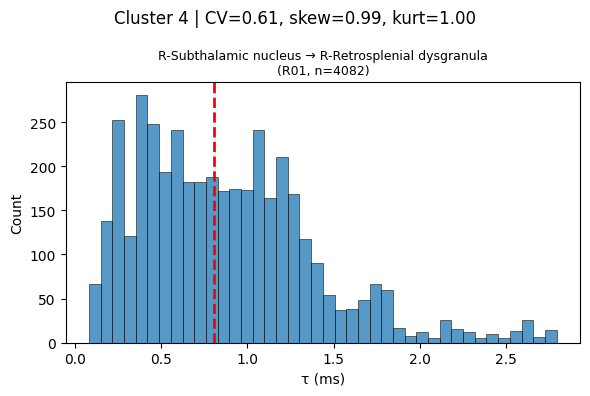

In [29]:
# Ejemplos por cluster
np.random.seed(42)

for c in sorted(df_feat_conn['cluster'].unique()):
    # Seleccionar 2 conexiones del cluster
    cluster_conns = df_feat_conn[df_feat_conn['cluster'] == c].head(2)
    
    if len(cluster_conns) == 0:
        continue
    
    n_plots = len(cluster_conns)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
    
    cluster_profile = df_feat_conn[df_feat_conn['cluster'] == c][feature_cols].median()
    
    for idx, (_, row) in enumerate(cluster_conns.iterrows()):
        i, j = int(row['roi_i']), int(row['roi_j'])
        
        # Tomar primera rata disponible para esta conexión
        rat_id = None
        for rid, data in cleaned_rats.items():
            if (i, j) in data:
                rat_id = rid
                break
        
        if rat_id is None:
            continue
            
        tau_ms = cleaned_rats[rat_id][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{row['pair_label'][:50]}\n({rat_id}, n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
        axes[idx].set_ylabel('Count')
    
    fig.suptitle(
        f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, '
        f'skew={cluster_profile["skew"]:.2f}, kurt={cluster_profile["kurt"]:.2f}',
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

Evaluando 16 configuraciones...


/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: '


✓ Grid search completo: 14 configuraciones válidas

Top 5 configuraciones:
 n_neighbors  min_dist  min_cluster_size  min_samples  n_clusters  silhouette  noise_pct
          20       0.0                10           10           3    0.518842   0.608519
          10       0.0               100            5           2    0.543297   8.722110
          10       0.2               100            5           2    0.497661   0.811359
          20       0.0                10            5          14    0.545967  11.156187
          20       0.2                10            5           2    0.452297   0.405680


/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Clustering final: 14 clusters + 114 noise


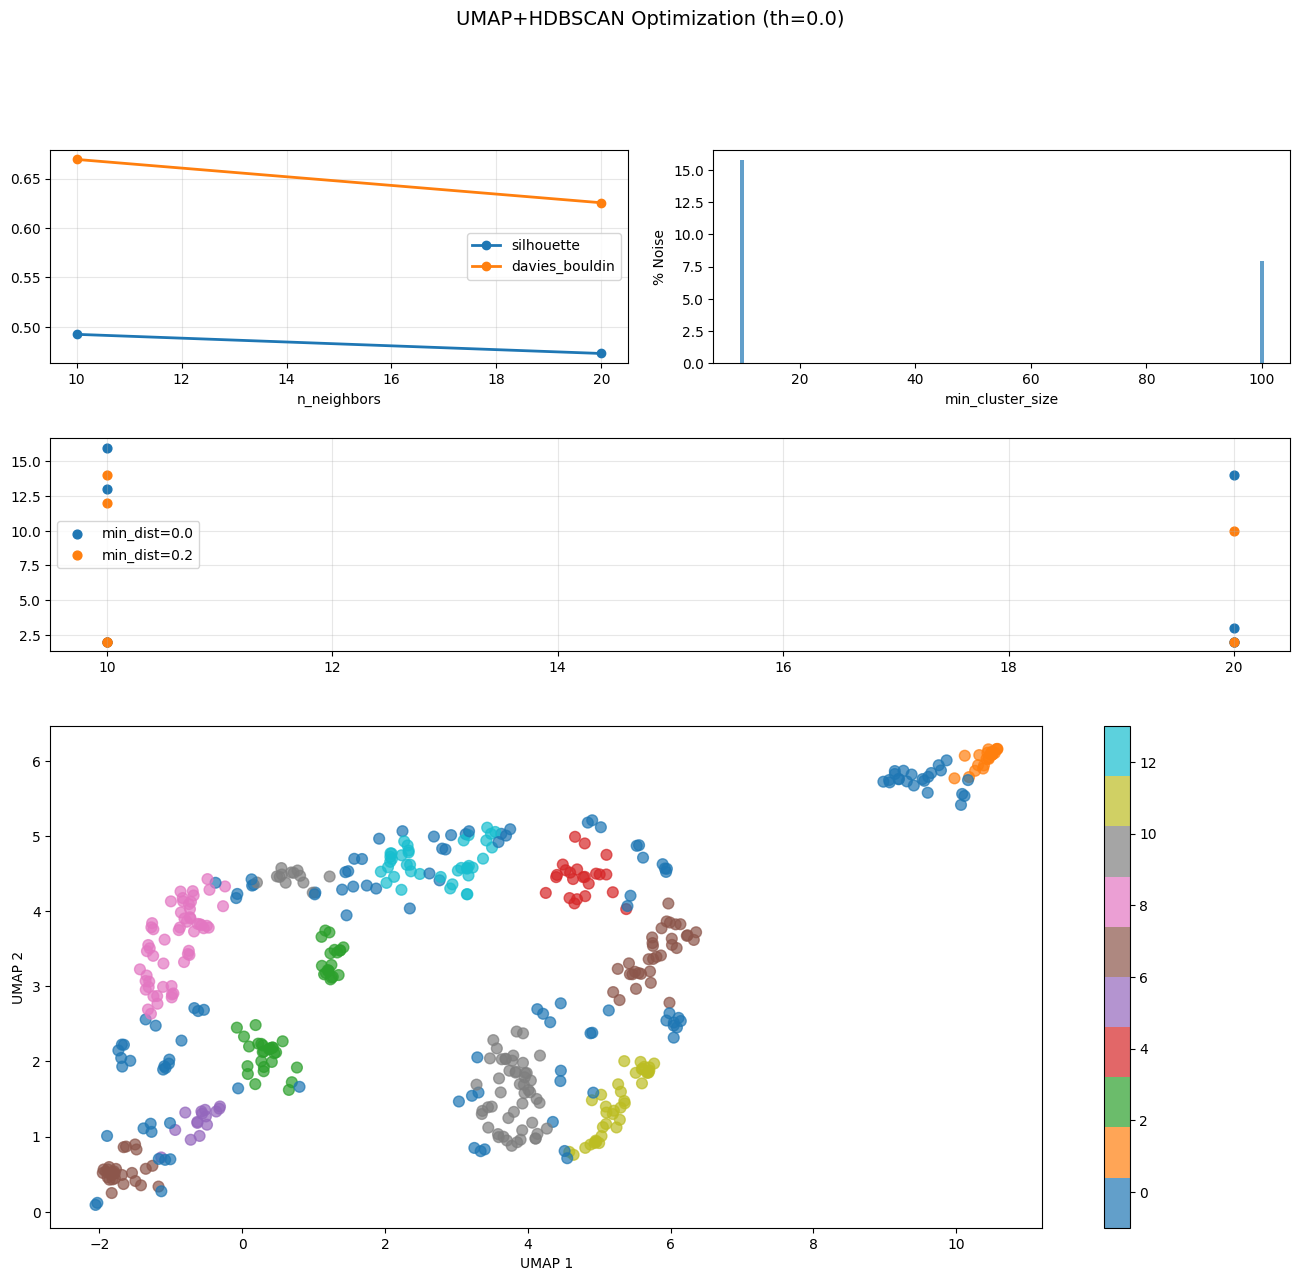

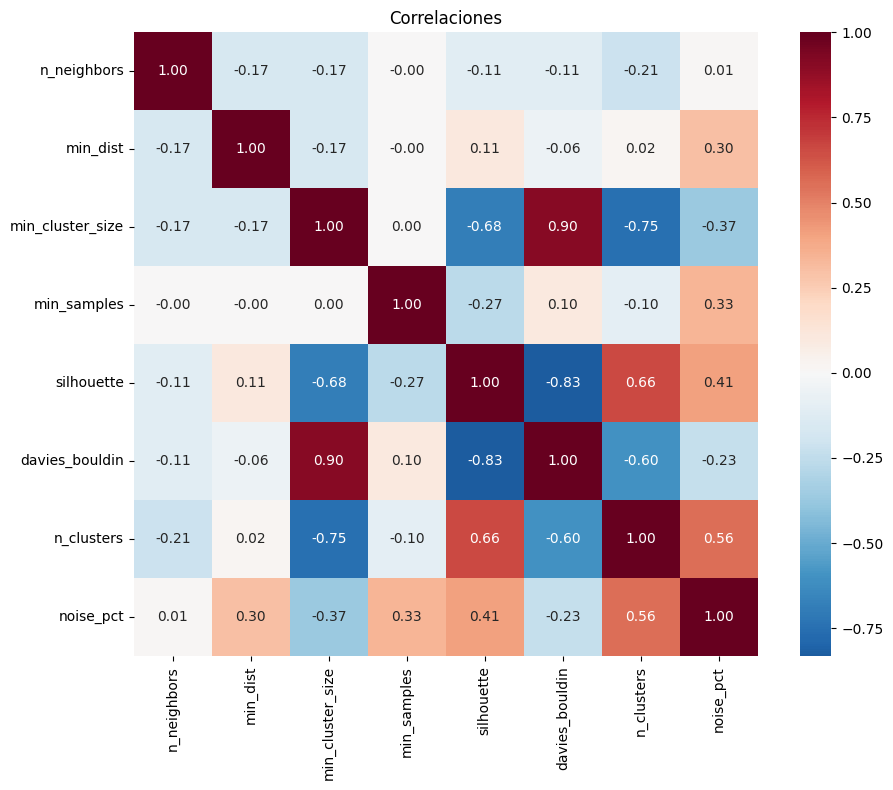

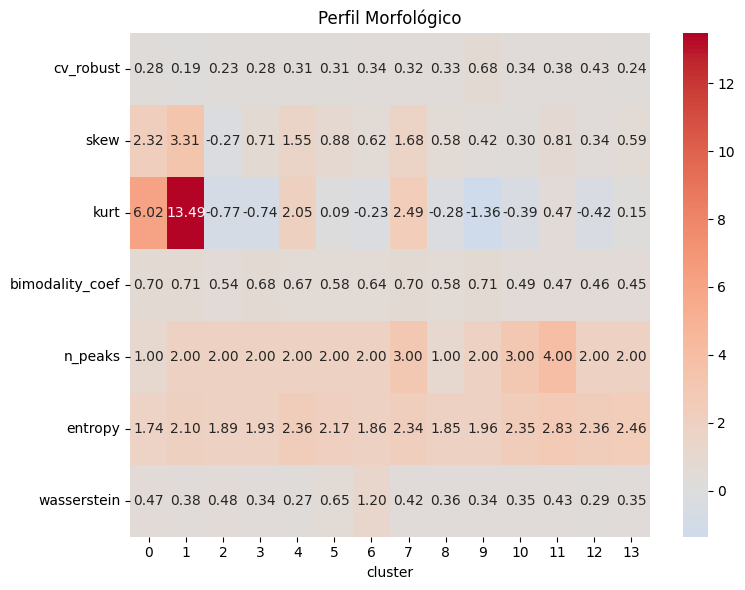


ESTADÍSTICAS CLUSTERING FINAL
Parámetros óptimos:
  n_neighbors=20, min_dist=0.0
  min_cluster_size=10, min_samples=10

Métricas:
  Silhouette: 0.519
  Davies-Bouldin: 0.370
  Calinski-Harabasz: 195.4
  Noise: 0.6%

Distribución por cluster:
cluster
-1     114
 0      11
 1      25
 2      27
 3      20
 4      23
 5      15
 6      29
 7      33
 8      56
 9      13
 10     50
 11     38
 12     20
 13     19
Name: count, dtype: int64


In [30]:

# Caracterizar
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(50).iterrows()]
df_feat = characterize_distributions_enhanced(cleaned_rats, top_pairs)

# Features para clustering (robustos a outliers)
X = df_feat[['cv_robust', 'skew', 'bimodality_coef', 'iqr_norm', 'wasserstein', 'ks_stat', 'mean', 'median', 'kurt', 'n_peaks', 'entropy', 'kl_div', 'range_norm']].values

feature_cols = ['cv_robust', 'skew', 'kurt', 'bimodality_coef', 
                'n_peaks', 'entropy', 'wasserstein']

corr_cols = ['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples',
             'silhouette', 'davies_bouldin', 'n_clusters', 'noise_pct']

X = df_feat[feature_cols].dropna().values
X_scaled = RobustScaler().fit_transform(X)

# ===== GRID SEARCH =====
param_grid = {
    'n_neighbors': [10, 20],
    'min_dist': [0.0, 0.2],
    'min_cluster_size': [10, 100],  # más grande → menos clusters
    'min_samples': [5, 10]
}

results = []
print(f"Evaluando {len(list(ParameterGrid(param_grid)))} configuraciones...")

for i, params in enumerate(ParameterGrid(param_grid)):
    # UMAP
    reducer = UMAP(n_neighbors=params['n_neighbors'], 
                   min_dist=params['min_dist'],
                   n_components=2, n_jobs=-1)
    X_umap = reducer.fit_transform(X_scaled)
    
    # HDBSCAN
    clusterer = HDBSCAN(min_cluster_size=params['min_cluster_size'],
                        min_samples=params['min_samples'], 
                        core_dist_n_jobs=-1)
    labels = clusterer.fit_predict(X_umap)
    
    # Métricas (solo no-ruido)
    mask = labels != -1
    n_noise = (~mask).sum()
    n_clustered = mask.sum()
    n_clusters = len(set(labels[mask])) if n_clustered > 0 else 0
    
    if n_clustered > 20 and n_clusters > 1:
        sil = silhouette_score(X_umap[mask], labels[mask])
        db = davies_bouldin_score(X_umap[mask], labels[mask])
        ch = calinski_harabasz_score(X_umap[mask], labels[mask])
        noise_pct = 100 * n_noise / len(labels)
        
        results.append({
            **params, 
            'silhouette': sil, 
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'n_clusters': n_clusters, 
            'noise_pct': noise_pct,
            'n_clustered': n_clustered
        })
    
    if (i+1) % 20 == 0:
        print(f"  {i+1}/{len(list(ParameterGrid(param_grid)))} completado")

df_grid = pd.DataFrame(results)

# Mejor configuración (multiobjetivo)
# Cambiar función de score
df_grid['score'] = (
    df_grid['silhouette'] / df_grid['silhouette'].max() - 
    df_grid['davies_bouldin'] / df_grid['davies_bouldin'].max() +
    df_grid['calinski_harabasz'] / df_grid['calinski_harabasz'].max() -
    df_grid['noise_pct'] / 100 -
    abs(df_grid['n_clusters'] - 4) / 10  # penaliza alejarse de k=4
)
df_grid = df_grid.sort_values('score', ascending=False)

print(f"\n✓ Grid search completo: {len(df_grid)} configuraciones válidas")
print("\nTop 5 configuraciones:")
print(df_grid.head(5)[['n_neighbors', 'min_dist', 'min_cluster_size', 'min_samples', 
                        'n_clusters', 'silhouette', 'noise_pct']].to_string(index=False))

# ===== CLUSTERING FINAL =====
best = df_grid.iloc[0]
reducer_final = UMAP(n_neighbors=int(best['n_neighbors']), 
                     min_dist=best['min_dist'],
                     n_components=2, random_state=42)
X_umap_final = reducer_final.fit_transform(X_scaled)

clusterer_final = HDBSCAN(min_cluster_size=int(best['min_cluster_size']),
                          min_samples=int(best['min_samples']))
df_feat['cluster'] = clusterer_final.fit_predict(X_umap_final)

mask_final = df_feat['cluster'] != -1
print(f"\nClustering final: {df_feat['cluster'].nunique()-1} clusters + {(~mask_final).sum()} noise")

# ===== PLOTS PRINCIPALES (4x4) =====
fig1 = plt.figure(figsize=(16, 14))
gs = fig1.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# Fila 1: Métricas vs parámetros
ax1 = fig1.add_subplot(gs[0, :2])
for metric in ['silhouette', 'davies_bouldin']:
    grouped = df_grid.groupby('n_neighbors')[metric].mean()
    ax1.plot(grouped.index, grouped.values, 'o-', label=metric, lw=2)
ax1.set_xlabel('n_neighbors'); ax1.legend(); ax1.grid(alpha=0.3)

ax2 = fig1.add_subplot(gs[0, 2:])
grouped = df_grid.groupby('min_cluster_size')['noise_pct'].mean()
ax2.bar(grouped.index, grouped.values, alpha=0.7)
ax2.set_xlabel('min_cluster_size'); ax2.set_ylabel('% Noise')

# Fila 2: Scatter n_clusters
ax3 = fig1.add_subplot(gs[1, :])
for md in sorted(df_grid['min_dist'].unique()):
    subset = df_grid[df_grid['min_dist'] == md]
    ax3.scatter(subset['n_neighbors'], subset['n_clusters'], 
               label=f'min_dist={md}', s=40)
ax3.legend(); ax3.grid(alpha=0.3)

# Fila 3-4: UMAP grande
ax4 = fig1.add_subplot(gs[2:, :])
scatter = ax4.scatter(X_umap_final[:, 0], X_umap_final[:, 1], 
                     c=df_feat['cluster'], cmap='tab10', s=60, alpha=0.7)
ax4.set_xlabel('UMAP 1'); ax4.set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=ax4)

plt.suptitle(f'UMAP+HDBSCAN Optimization (th=0.0)', fontsize=14)
plt.savefig(f'clustering_main_th_0.0.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== HEATMAPS SEPARADOS =====
# Correlaciones
fig2, ax = plt.subplots(1, 1, figsize=(10, 8))
corr_matrix = df_grid[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True)
ax.set_title('Correlaciones')
plt.tight_layout()
plt.savefig(f'correlations_th_0.0.png', dpi=150)
plt.show()

# Perfil clusters
fig3, ax = plt.subplots(1, 1, figsize=(8, 6))
cluster_profiles = df_feat[mask_final].groupby('cluster')[feature_cols].median()
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax)
ax.set_title('Perfil Morfológico')
plt.tight_layout()
plt.savefig(f'profiles_th_0.0.png', dpi=150)
plt.show()

# ===== ESTADÍSTICAS FINALES =====
print("\n" + "="*70)
print("ESTADÍSTICAS CLUSTERING FINAL")
print("="*70)
print(f"Parámetros óptimos:")
print(f"  n_neighbors={int(best['n_neighbors'])}, min_dist={best['min_dist']}")
print(f"  min_cluster_size={int(best['min_cluster_size'])}, min_samples={int(best['min_samples'])}")
print(f"\nMétricas:")
print(f"  Silhouette: {best['silhouette']:.3f}")
print(f"  Davies-Bouldin: {best['davies_bouldin']:.3f}")
print(f"  Calinski-Harabasz: {best['calinski_harabasz']:.1f}")
print(f"  Noise: {best['noise_pct']:.1f}%")
print(f"\nDistribución por cluster:")
print(df_feat['cluster'].value_counts().sort_index())

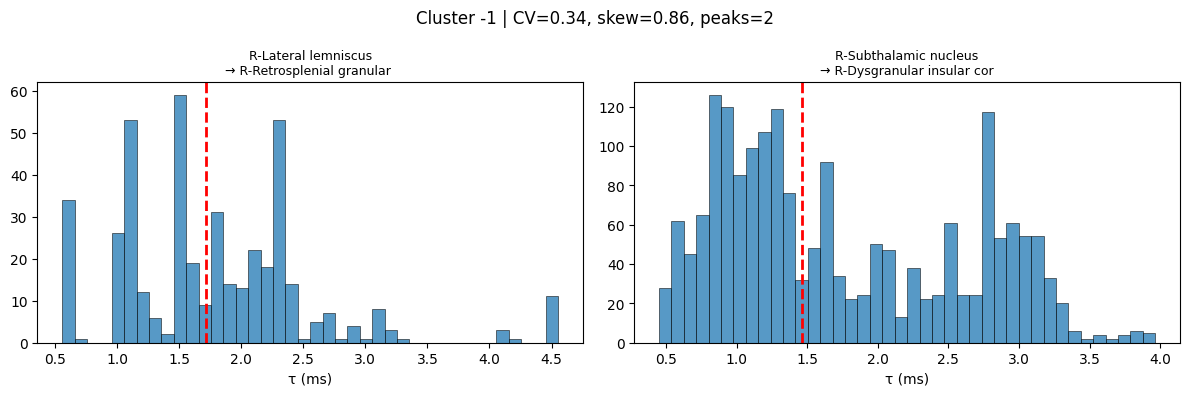

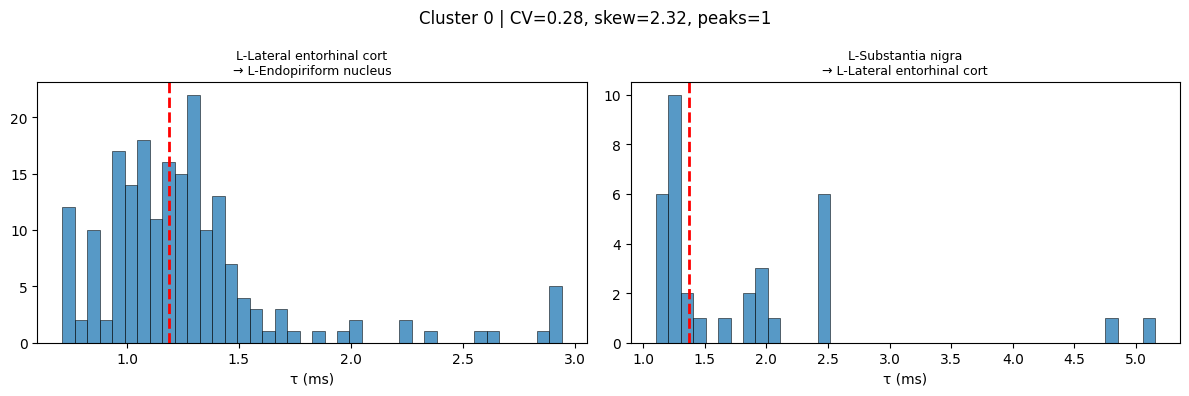

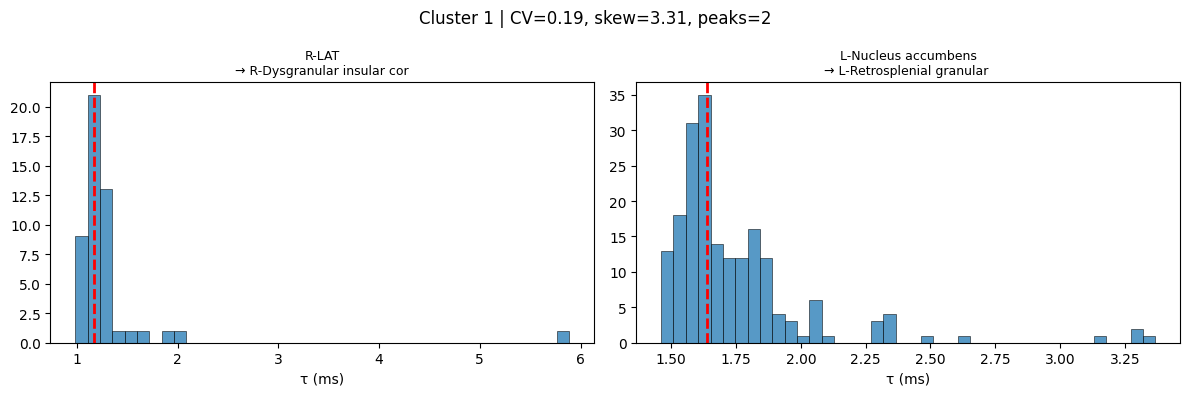

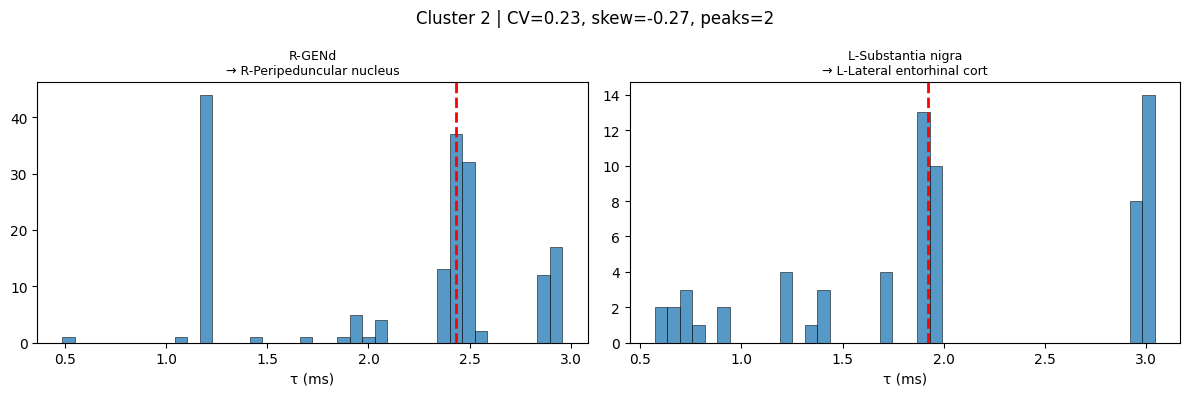

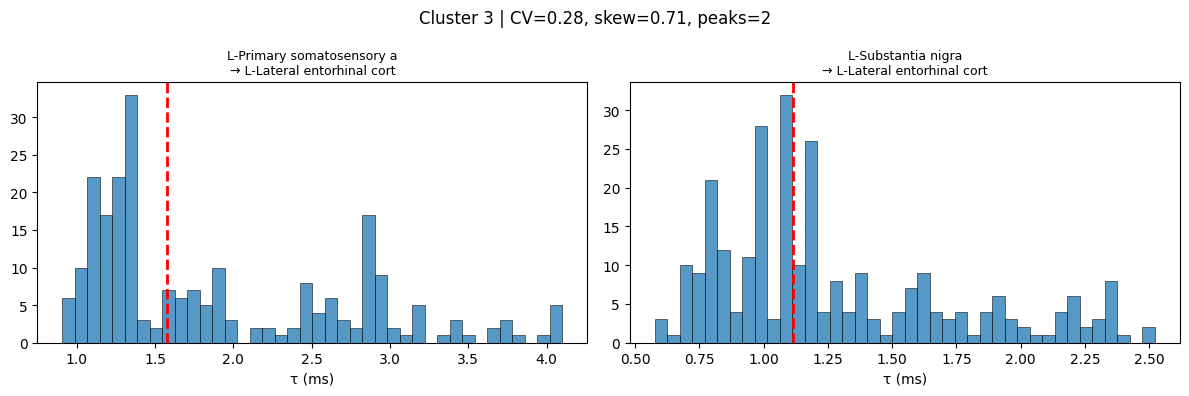

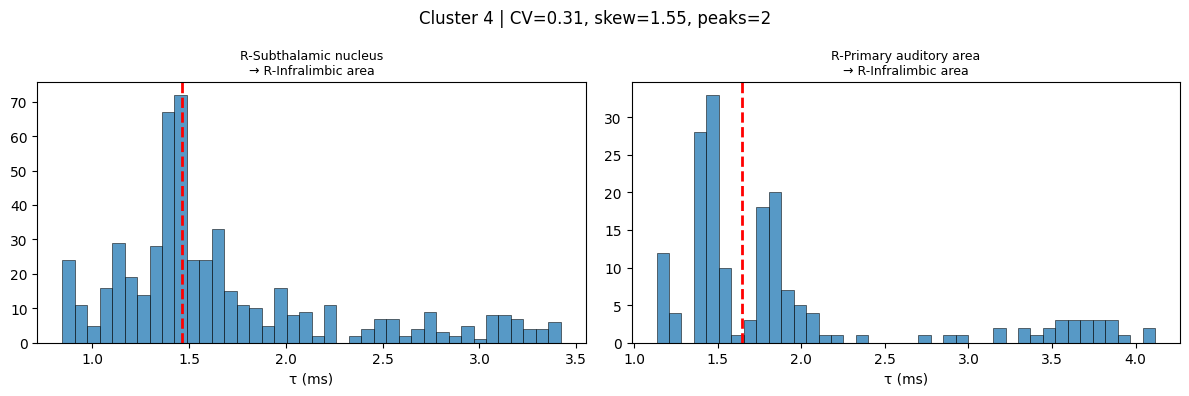

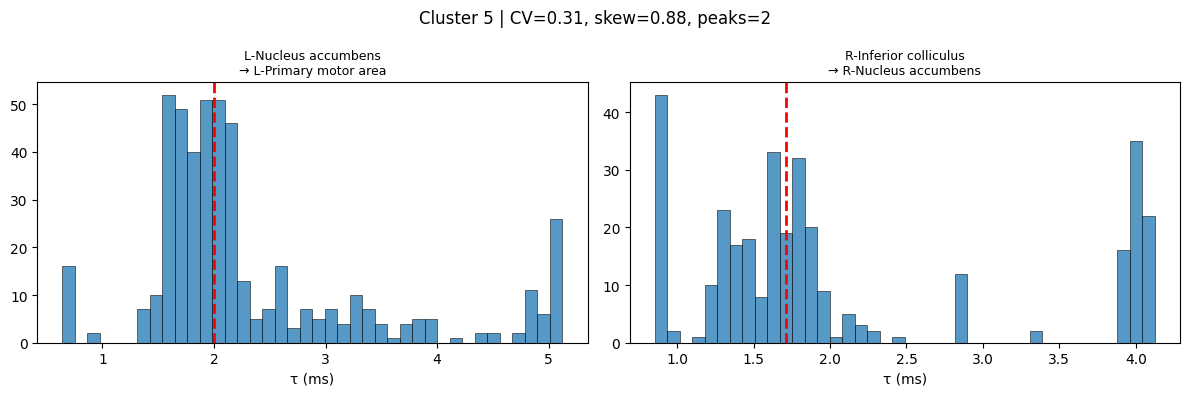

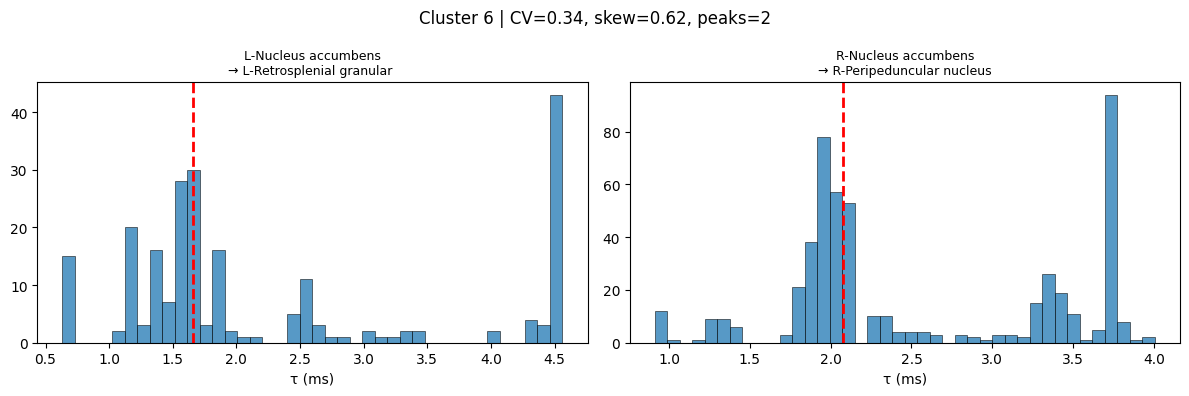

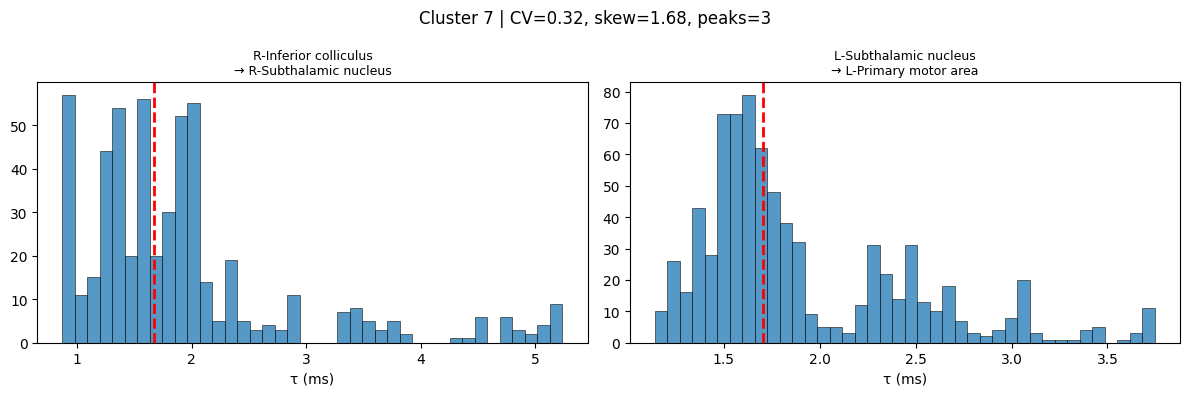

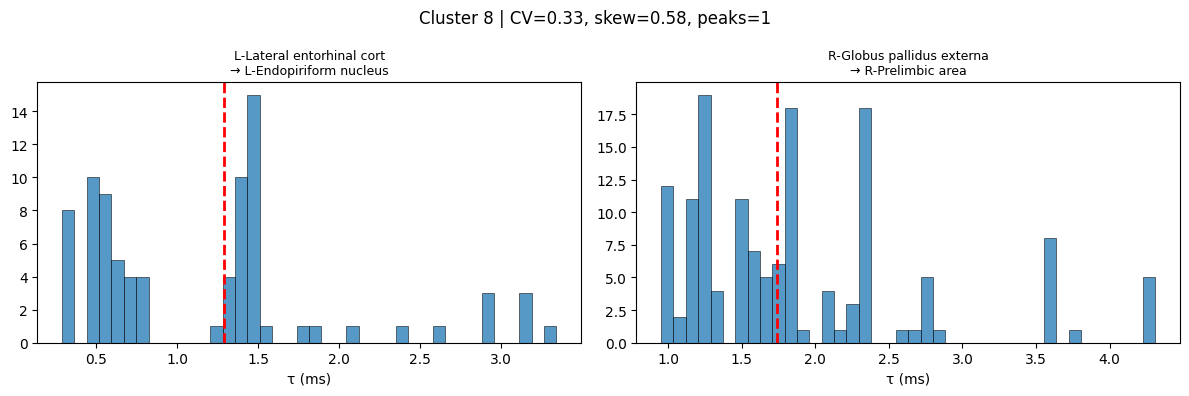

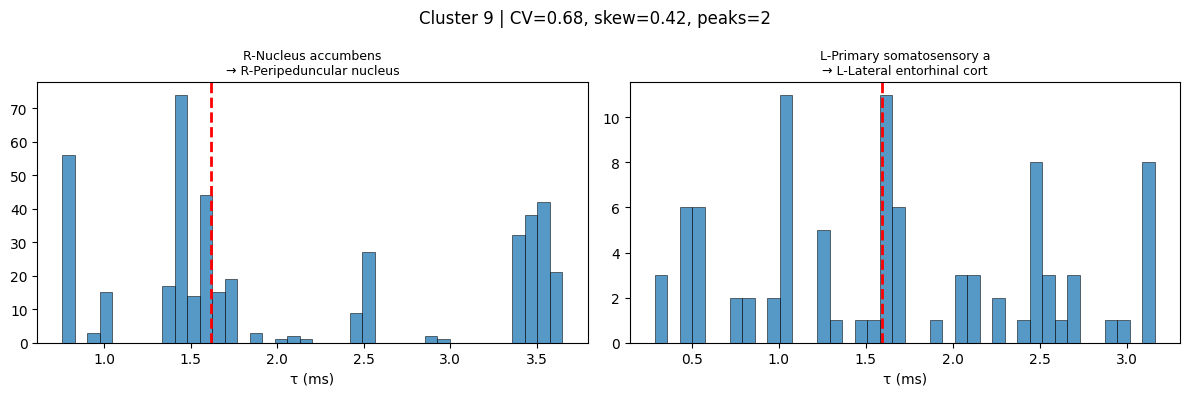

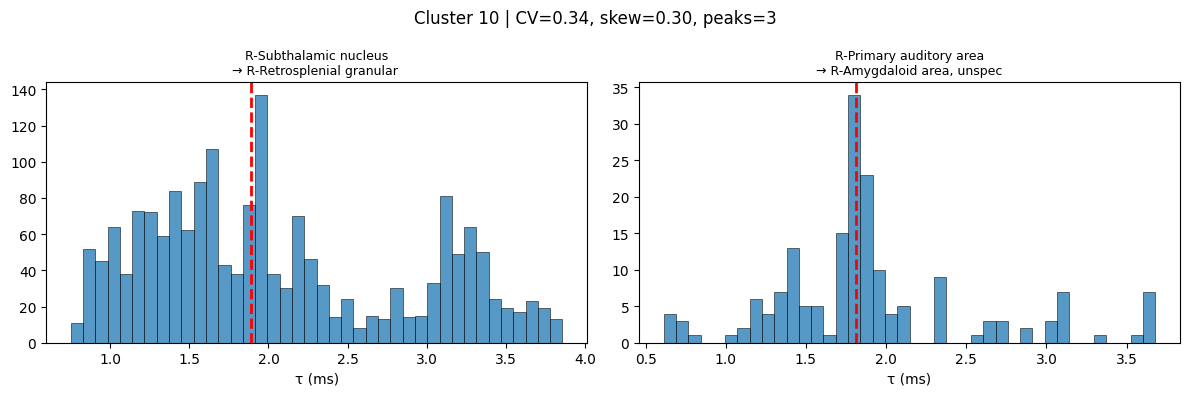

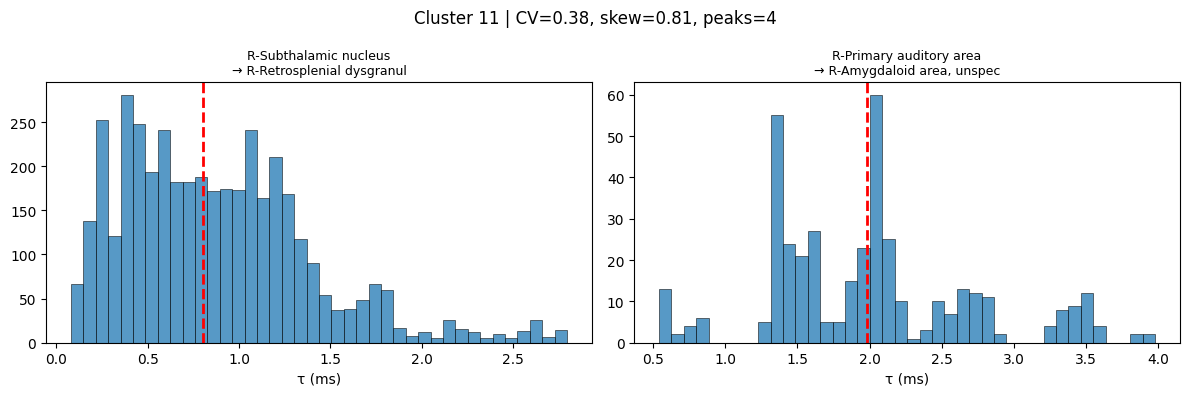

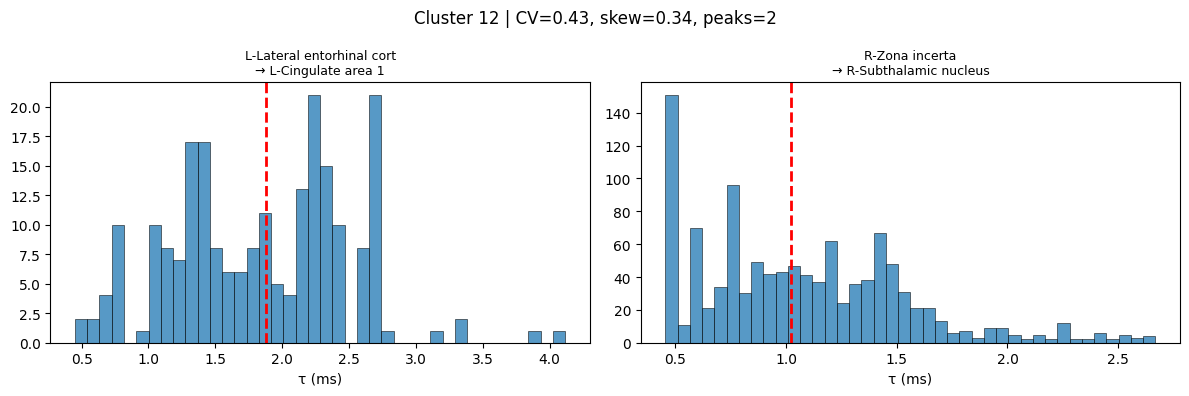

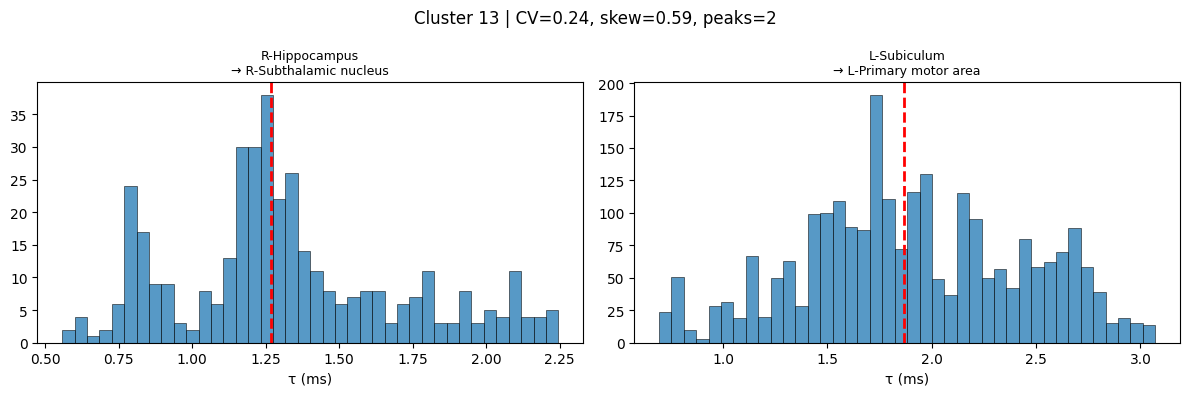

In [31]:
# 2 ejemplos por cluster
np.random.seed(42)
for c in sorted(df_feat['cluster'].unique()):
    # Tomar 2 pares distintos del cluster
    cluster_pairs = df_feat[df_feat['cluster'] == c][['roi_i', 'roi_j', 'rat_id']].drop_duplicates(['roi_i', 'roi_j']).head(2)
    
    if len(cluster_pairs) == 0:
        continue
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    cluster_profile = df_feat[df_feat['cluster'] == c][['cv_robust', 'skew', 'n_peaks']].median()
    
    for idx, (_, row) in enumerate(cluster_pairs.iterrows()):
        i, j, rat = int(row['roi_i']), int(row['roi_j']), row['rat_id']
        tau_ms = cleaned_rats[rat][(i,j)][:, COL_TAU] * 1e3
        
        axes[idx].hist(tau_ms, bins=40, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=2)
        axes[idx].set_title(f"{roi_label(i, name_map)[:25]}\n→ {roi_label(j, name_map)[:25]}", fontsize=9)
        axes[idx].set_xlabel('τ (ms)')
    
    fig.suptitle(f'Cluster {c} | CV={cluster_profile["cv_robust"]:.2f}, skew={cluster_profile["skew"]:.2f}, peaks={cluster_profile["n_peaks"]:.0f}', fontsize=12)
    plt.tight_layout()
    plt.show()